# Steps
1. Choose data scenario.
2. Generate the dataset accordingly.
5. Choose 'fixed' configuration.
6. For each 'fixed' configuration, optimize the other parameters based on RMSE.
7. Given optimal setting, run popularity bias analysis for every version of the 'fixed' configuration.

## Libraries

In [1]:
import os

os.environ["MKL_THREADING_LAYER"] = "TBB"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
# for random generation


# basic functions
import pandas as pd

pd.options.display.max_rows = 100
import pickle

# custom-made functions
import modelling_mf
from data_generation import generate_data
from optimize_hp import optimize_lkpy, optimize_cornac

# lenskit RS library
from lenskit.algorithms import als


# cornac RS library
from cornac.models import MF

## Fairbook data and parameters

In [2]:
data = "fairbook"
# user-item interactions
fairbook_ratings = pd.read_csv("data/" + data + "_events.csv")

In [3]:
user_col = "user"  # the name of the column that includes the users
item_col = "item"  # the name of the column that includes the items
predict_col = "rating"  # the name of the column that includes the interaction

## Scenarios

1. There is no general relation between popularity and rating: uniformly_random
2. Popular items are rated higher by the users.: popularity_good
3. Popular items are rated lower by the users.: popilarity_bad
4. Popular items are rated higher by users with big profiles.: popularity_good_for_bp_ur
5. Popular items are rated lower by users with big profiles.: popularity_bad_for_bp_ur

In [4]:
data_strategies = [
    "uniformly_random",
    "popularity_good",
    "popularity_bad",
    "popularity_good_for_bp_ur",
    "popularity_bad_for_bp_ur",
]

## Optimize, train, evaluate LKPY
- **Algorithm**
- **Fixed parameters**
- **To-optimize parameters**

In [5]:
algo_versions = {"MF": [{"bias": True}, {"bias": False}]}

In [6]:
evaluation_way = "cross_validation"
verbose = False
plot = True
save_plot = True  # save the plots
fallback = False
nr_recs = 10
sampling_strategy = "frac"
partition_way = "user"

uniformly_random {'bias': True}
We got them already
nr of longtail 5082
3.9952830188679247
nr of longtail 5298
4.165094339622642
nr of longtail 5551
4.363993710691824
nr of longtail 5474
4.30684500393391
nr of longtail 5396
4.245476003147128


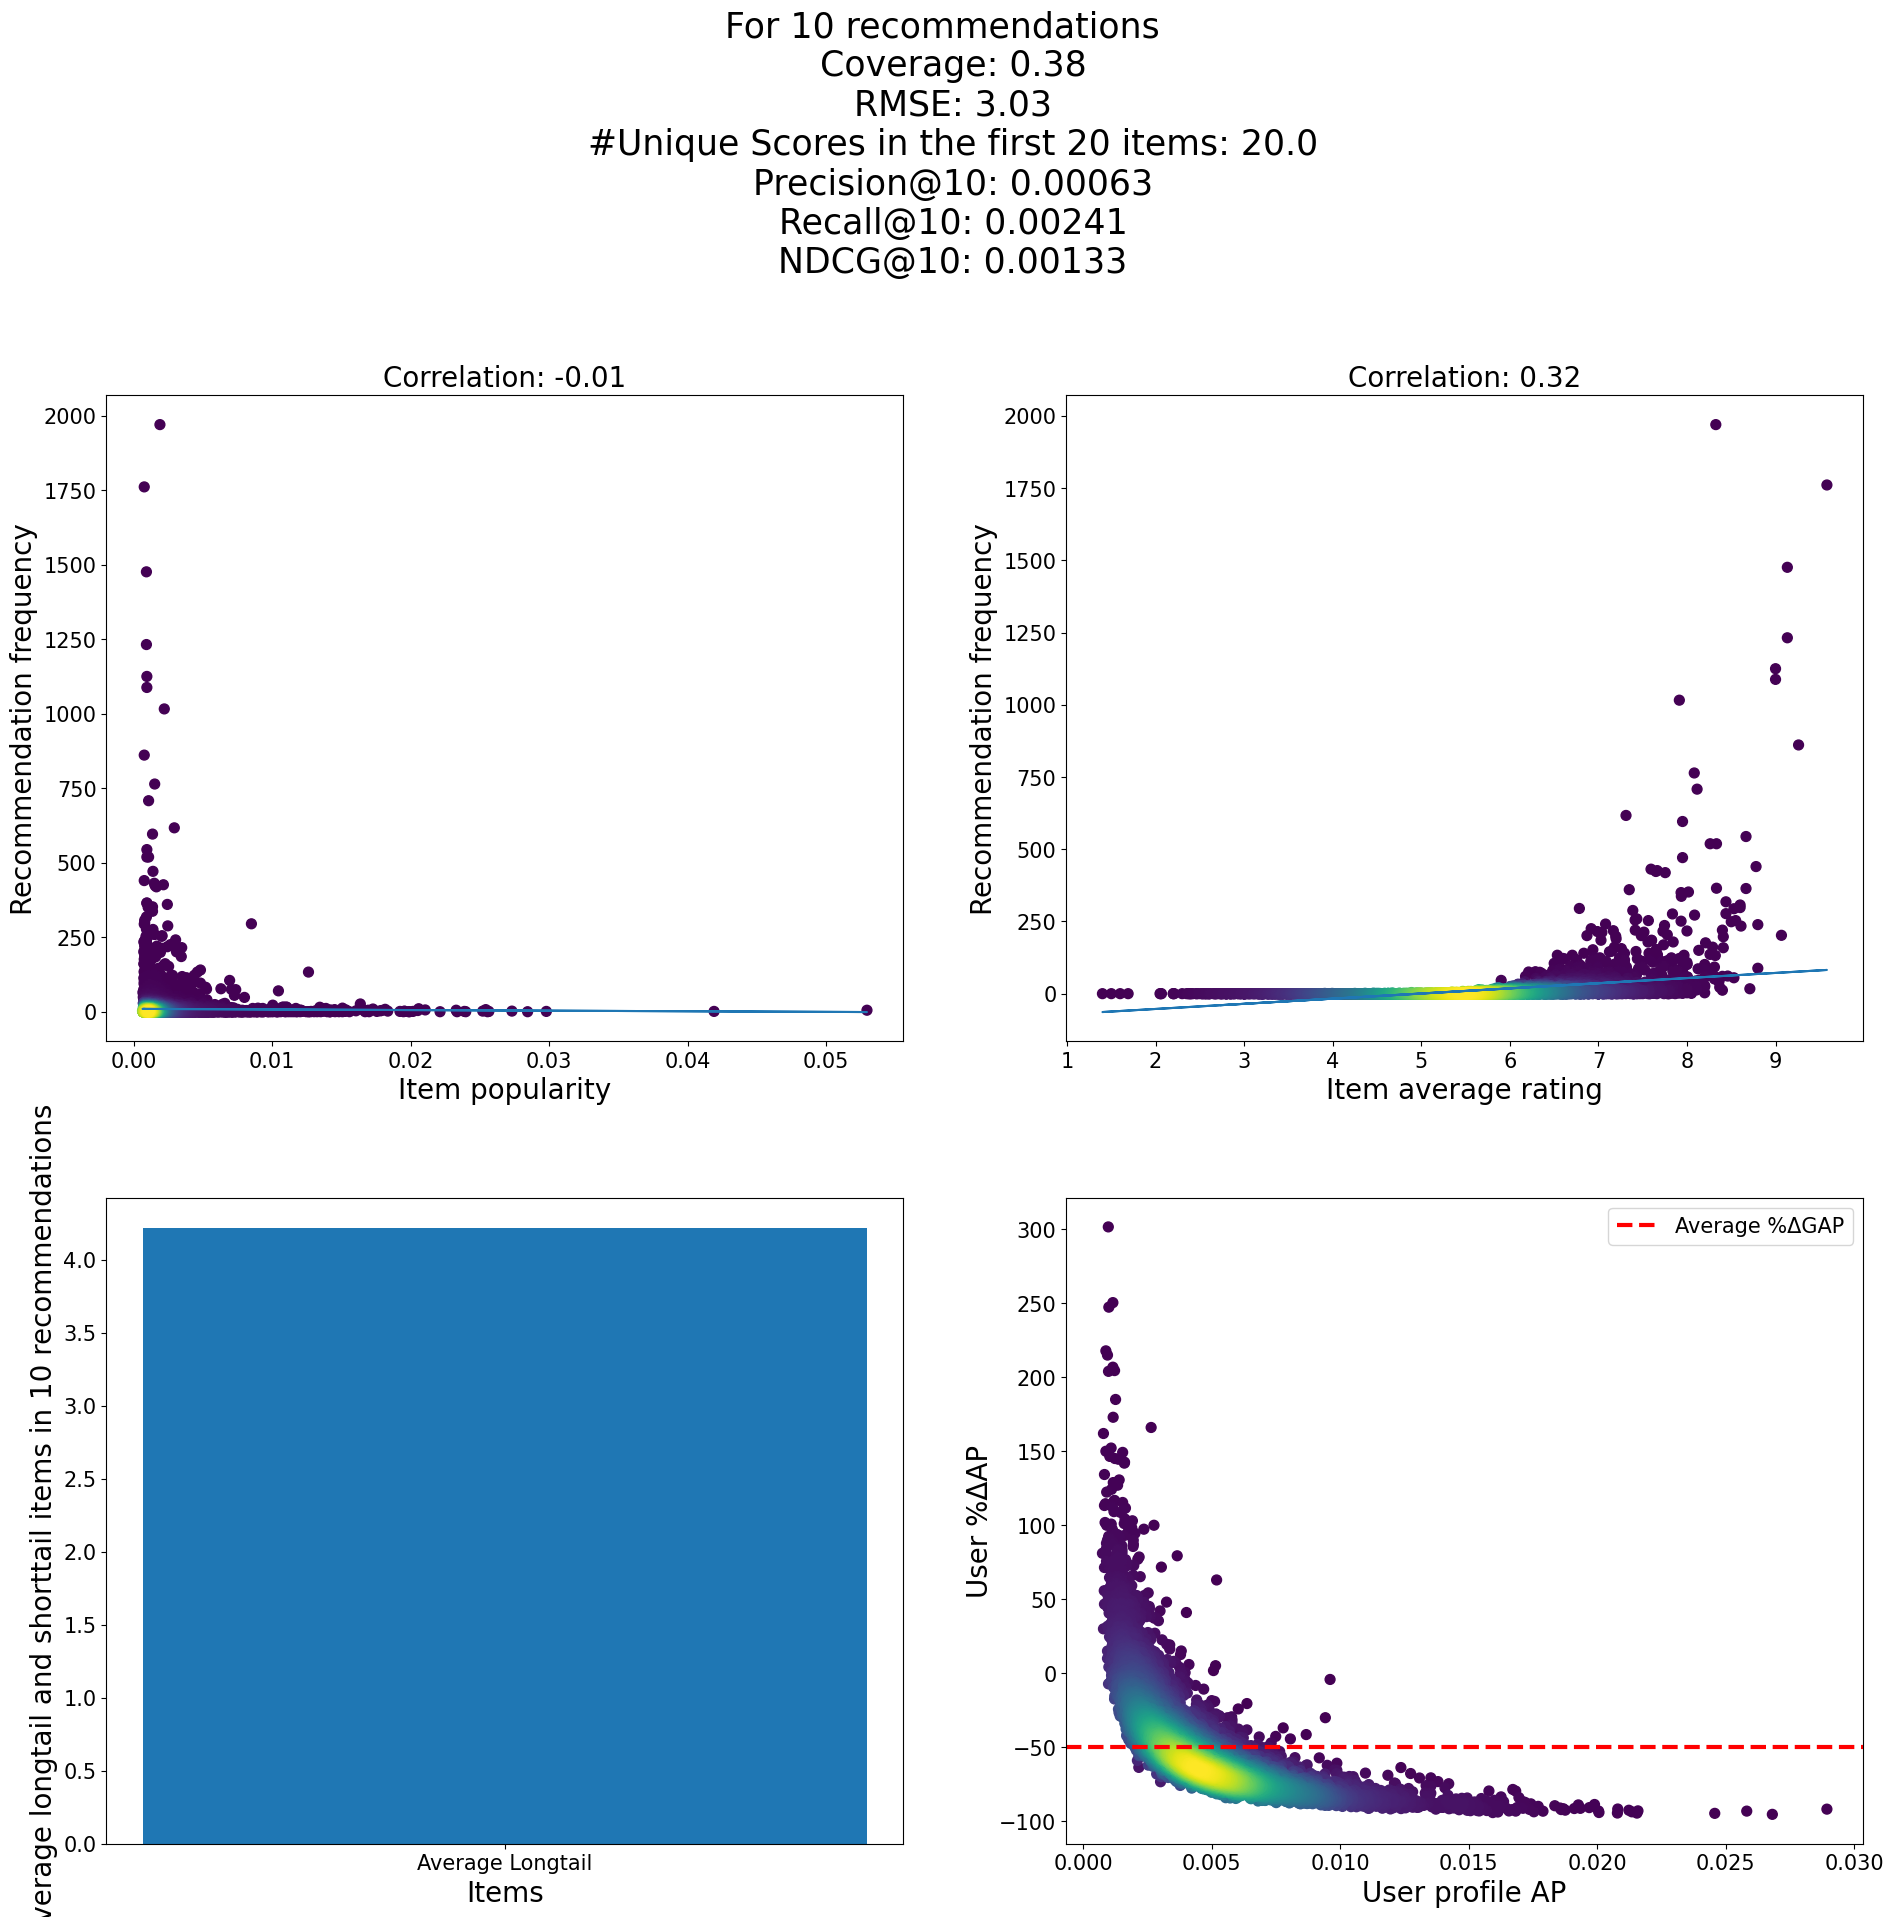

uniformly_random {'bias': False}
We got them already
nr of longtail 6104
4.79874213836478
nr of longtail 6733
5.293238993710692
nr of longtail 6667
5.241352201257862
nr of longtail 6872
5.406766325727774
nr of longtail 6746
5.307631785995279


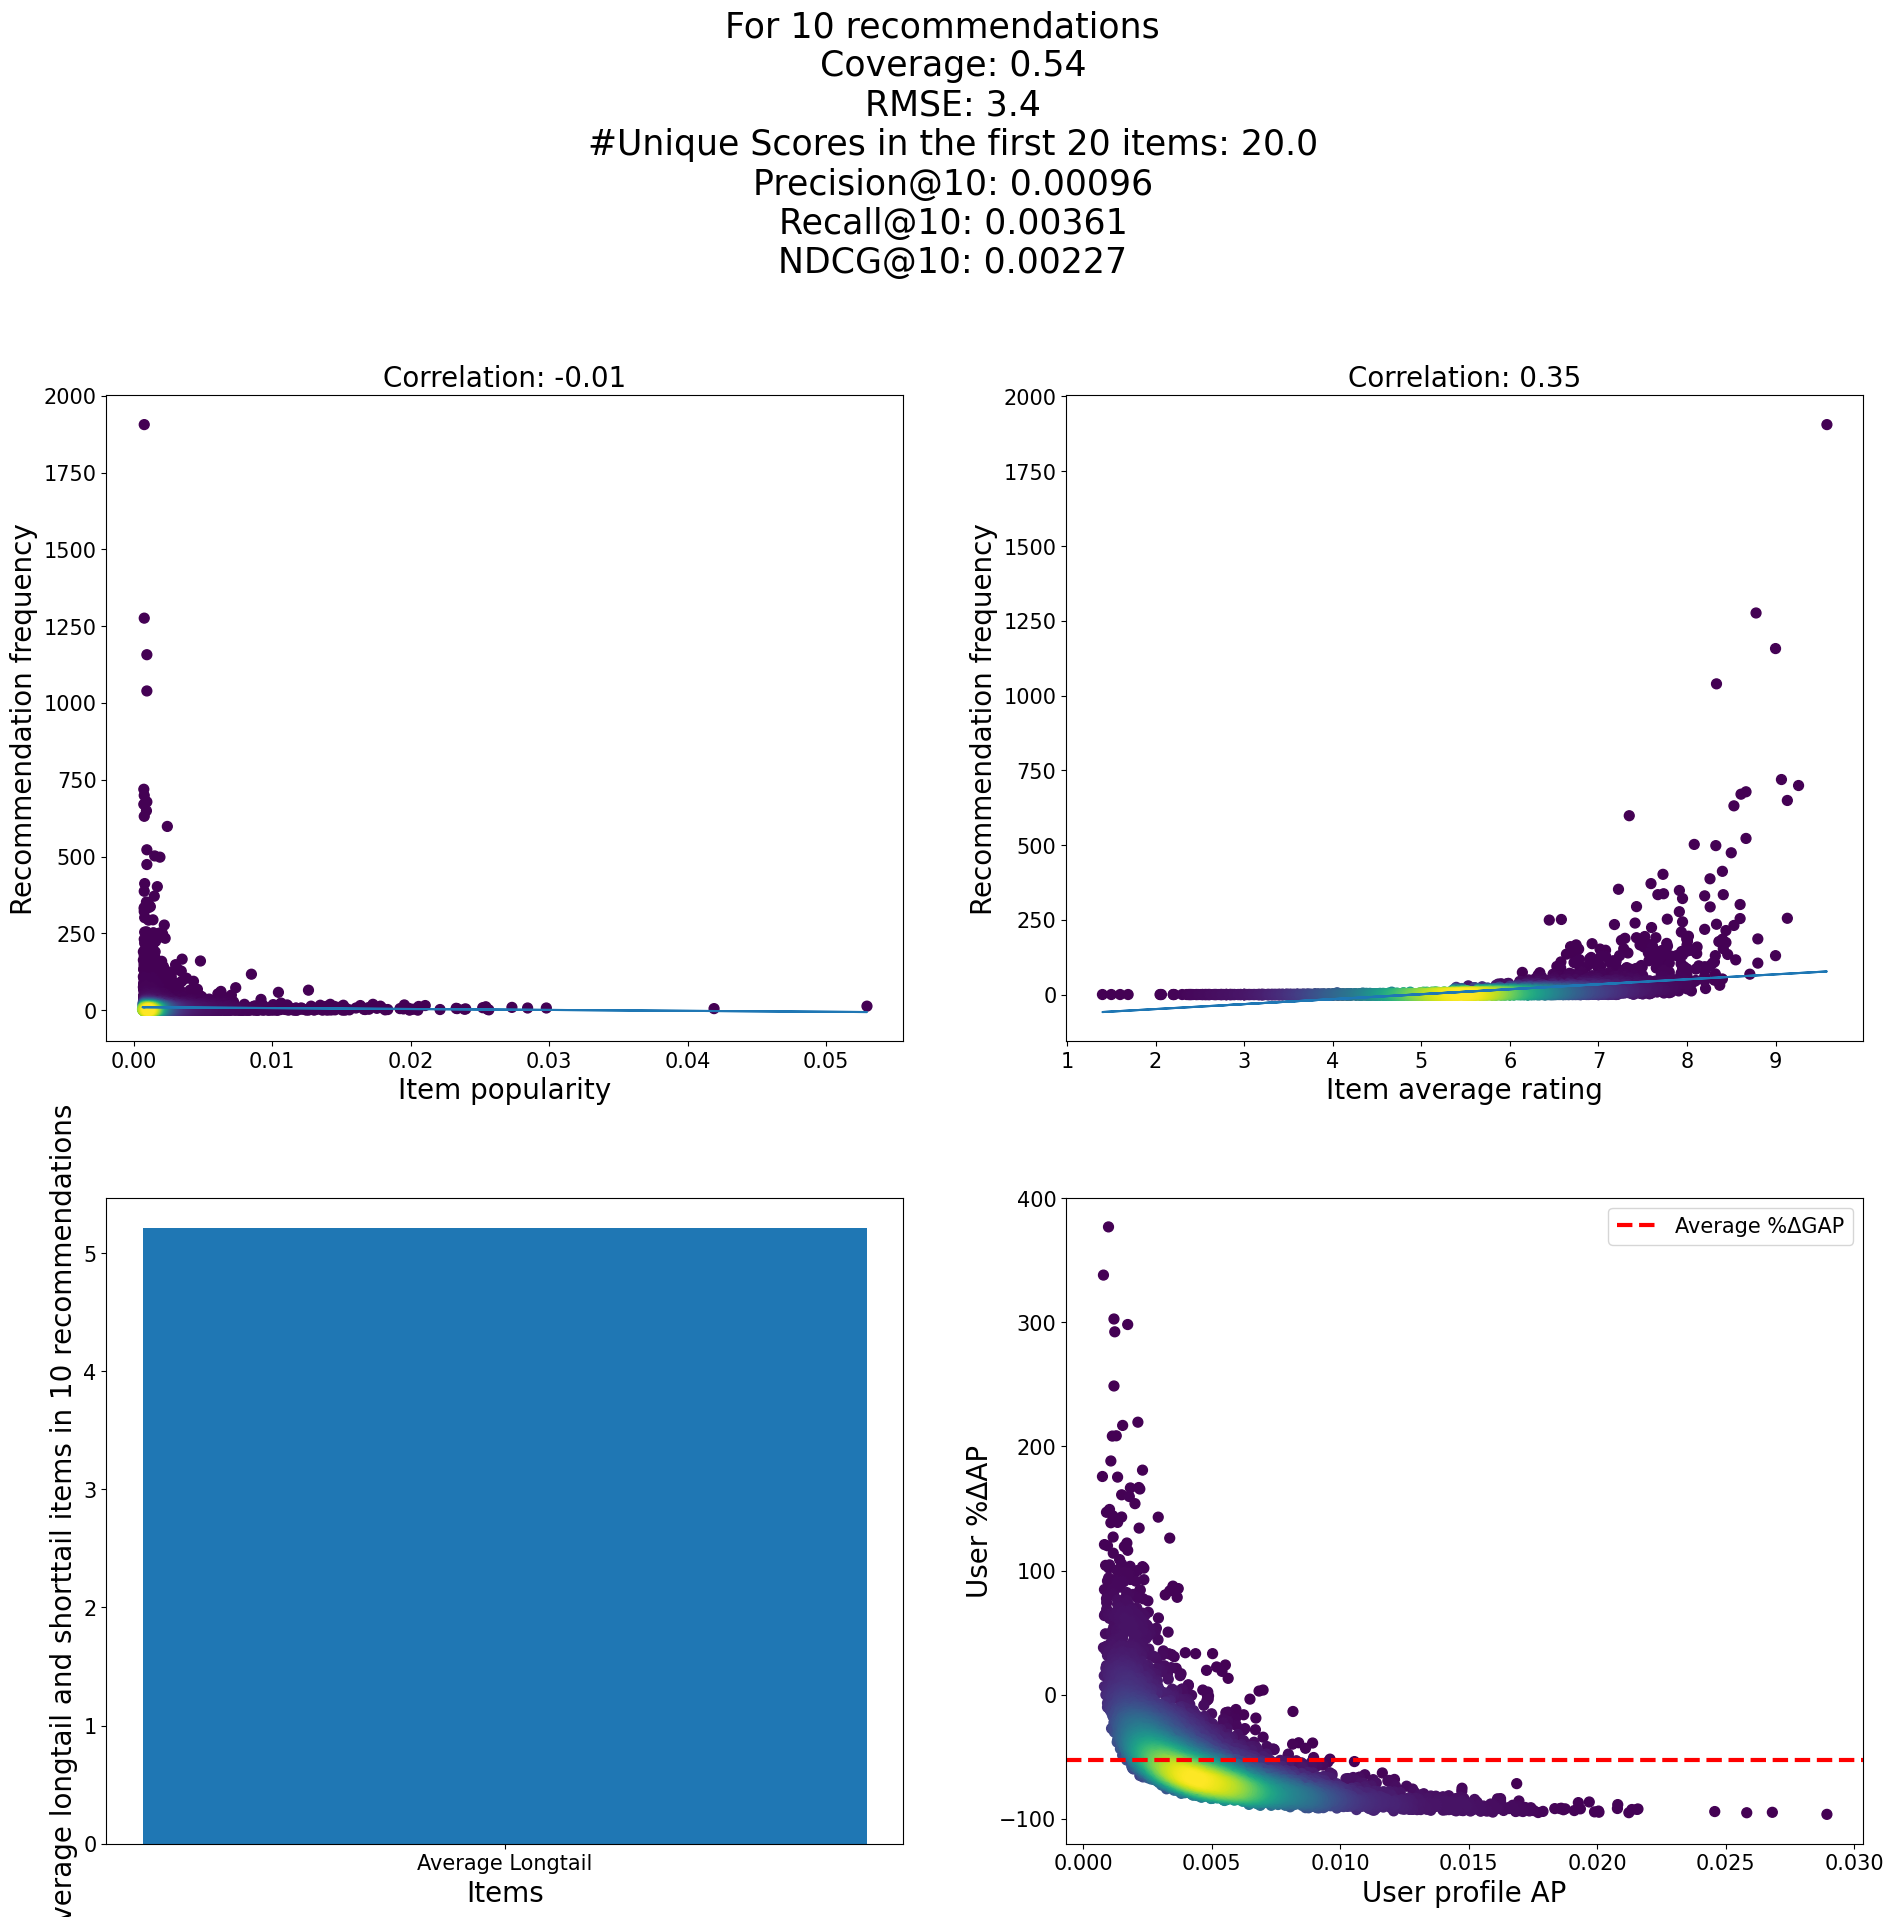

popularity_good {'bias': True}
We got them already
nr of longtail 0
0.0
nr of longtail 0
0.0
nr of longtail 0
0.0
nr of longtail 0
0.0
nr of longtail 0
0.0


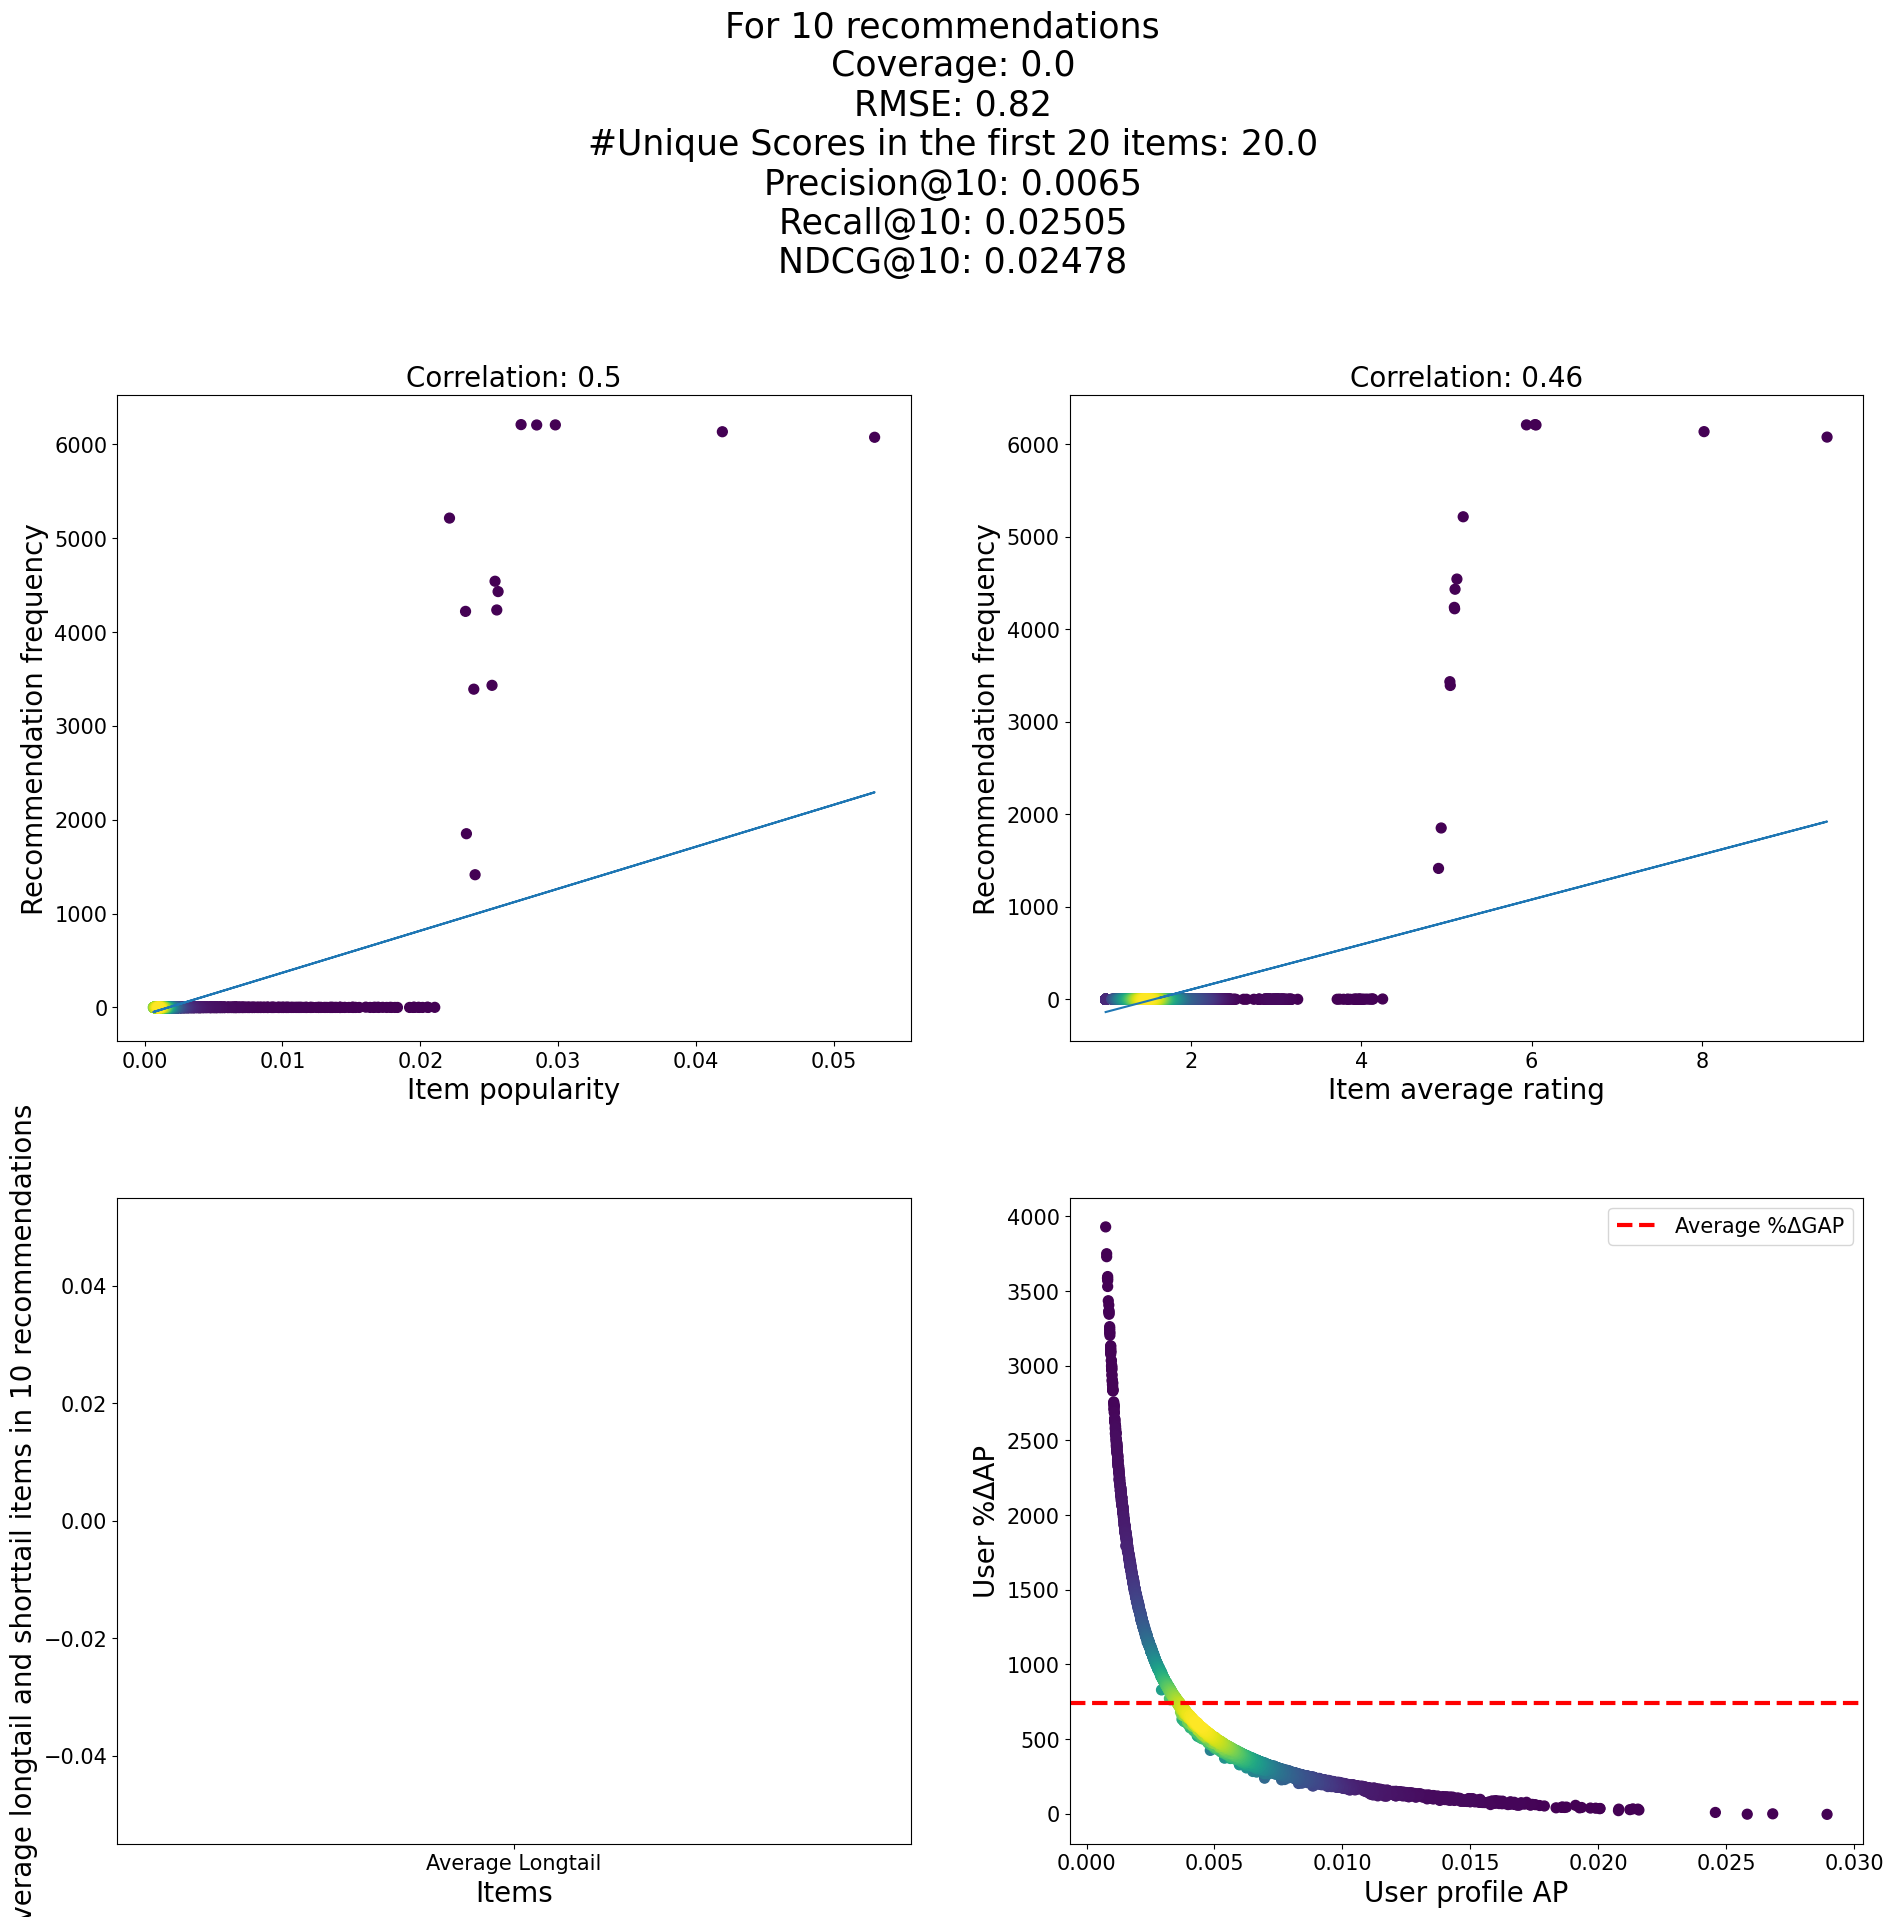

popularity_good {'bias': False}
We got them already
nr of longtail 0
0.0
nr of longtail 0
0.0
nr of longtail 0
0.0
nr of longtail 0
0.0
nr of longtail 1
0.0007867820613690008


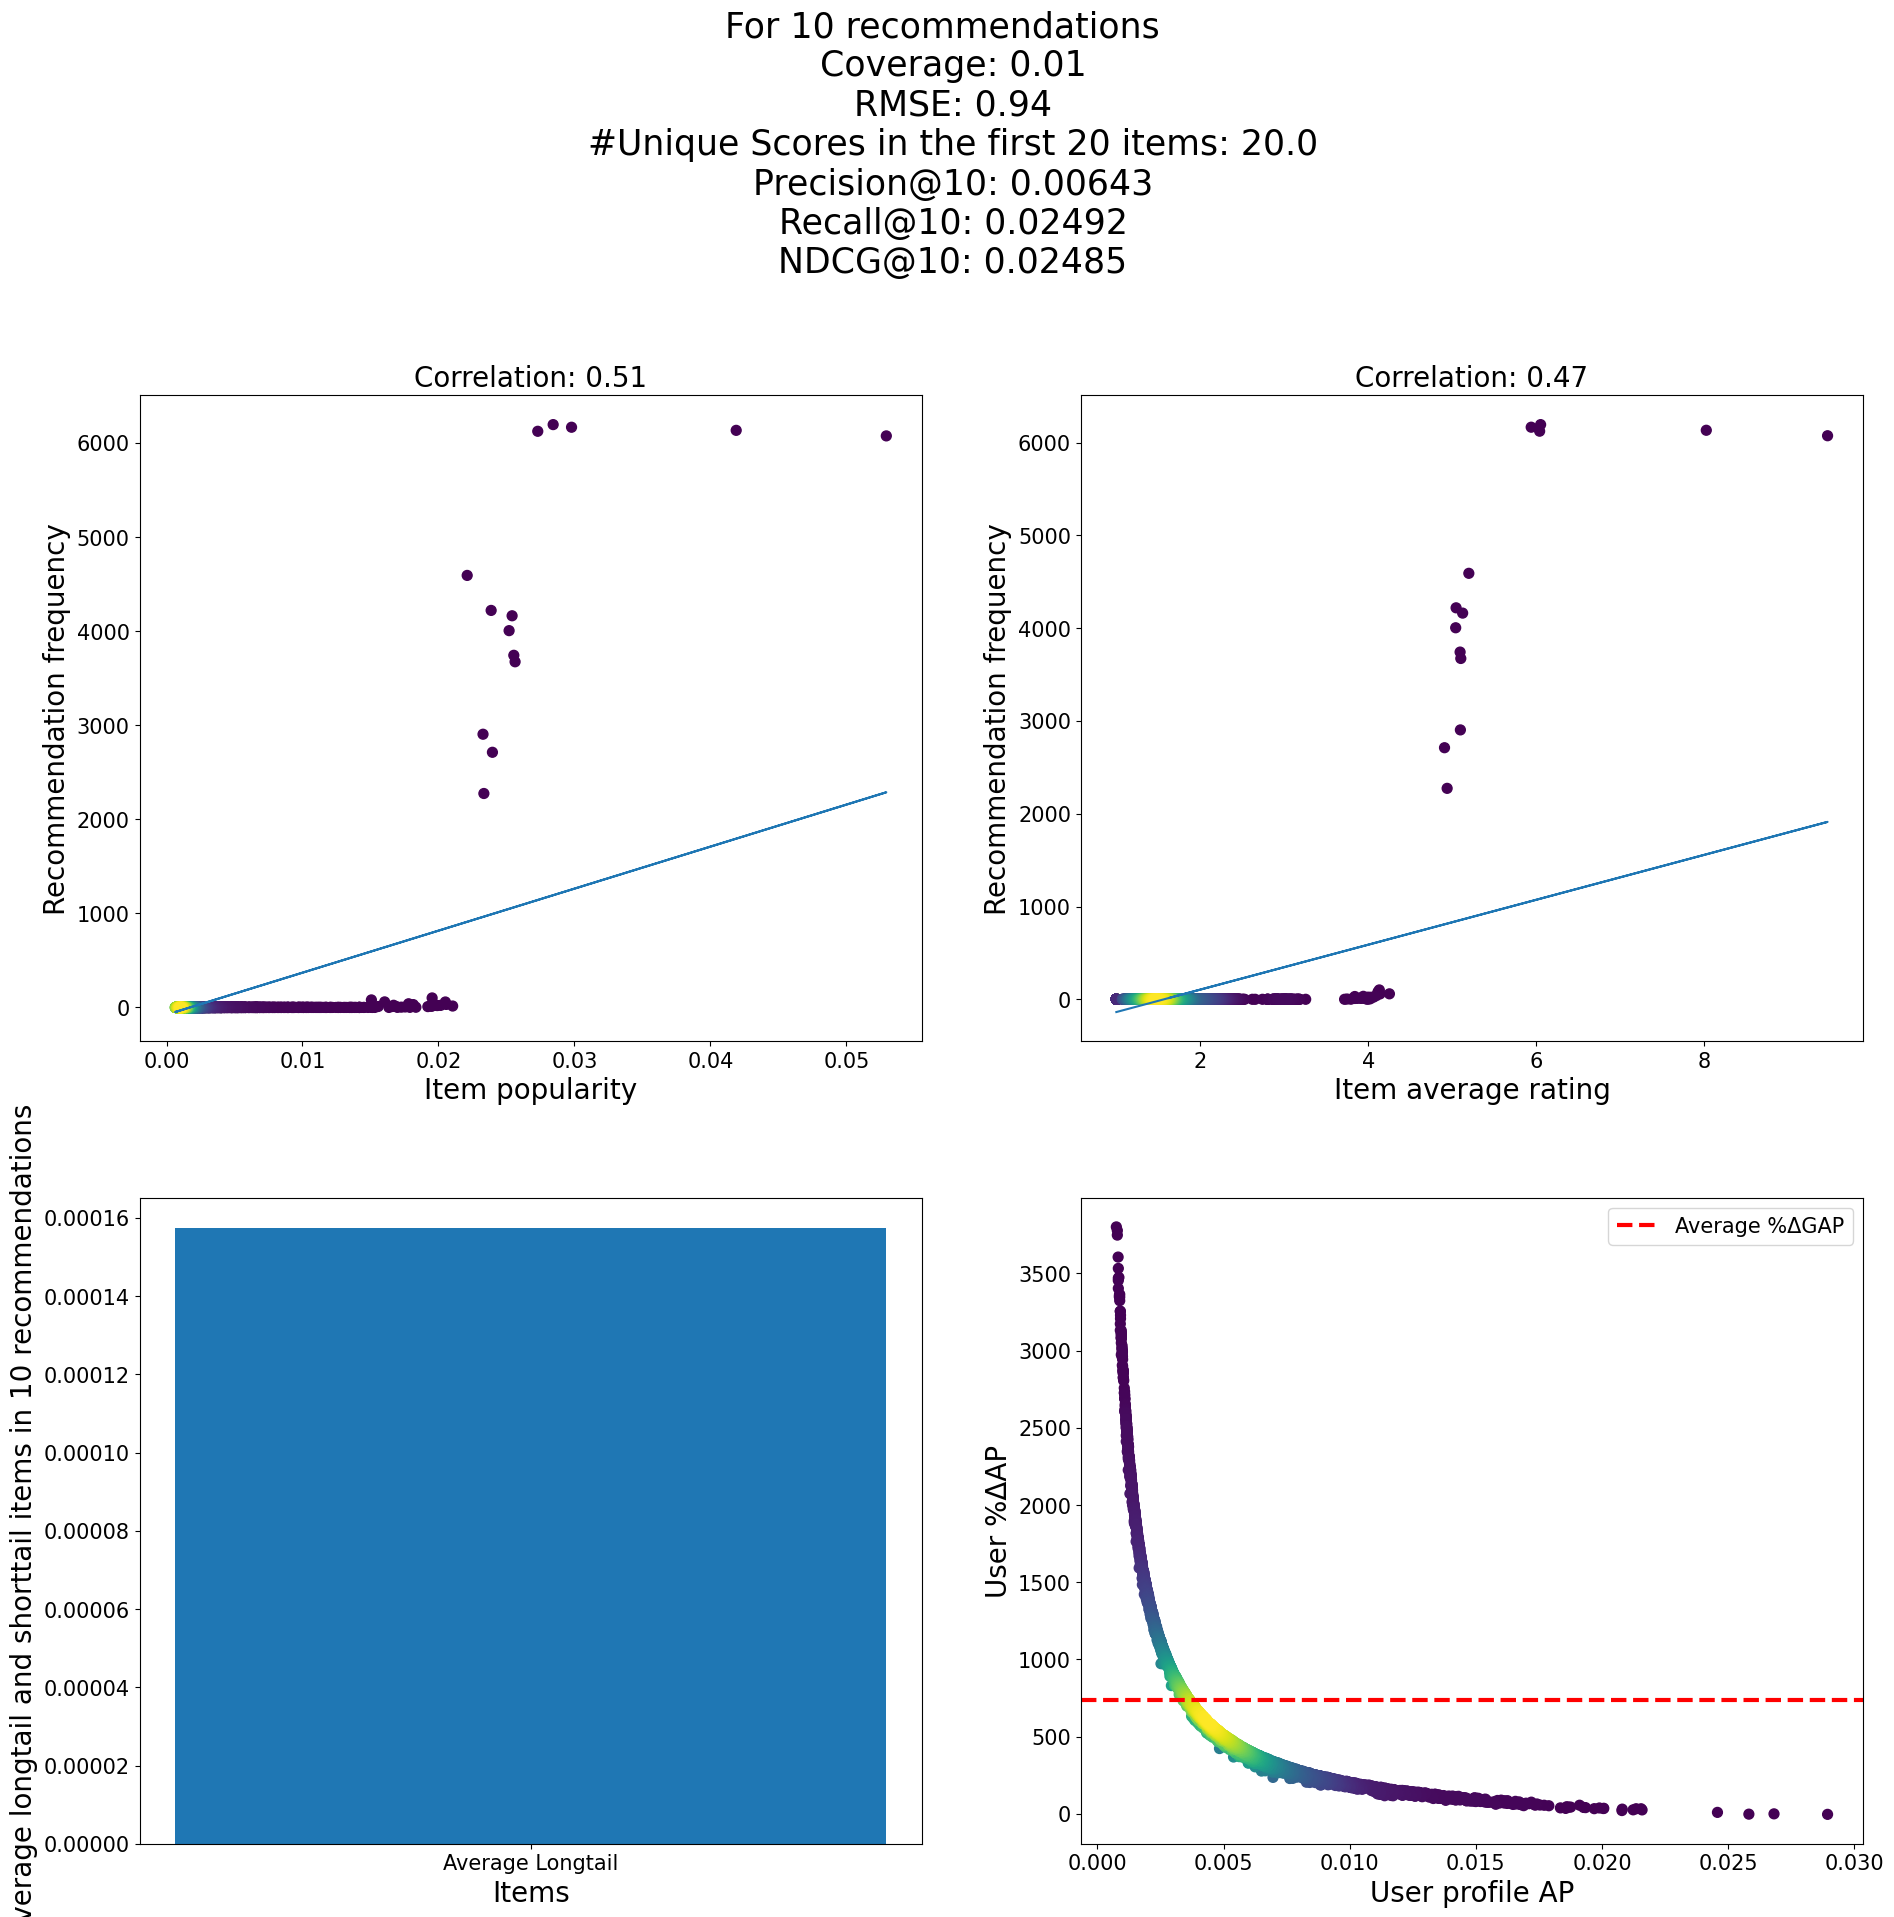

popularity_bad {'bias': True}
We got them already
nr of longtail 765
0.6014150943396226
nr of longtail 736
0.5786163522012578
nr of longtail 684
0.5377358490566038
nr of longtail 730
0.5743509047993706
nr of longtail 744
0.5853658536585366


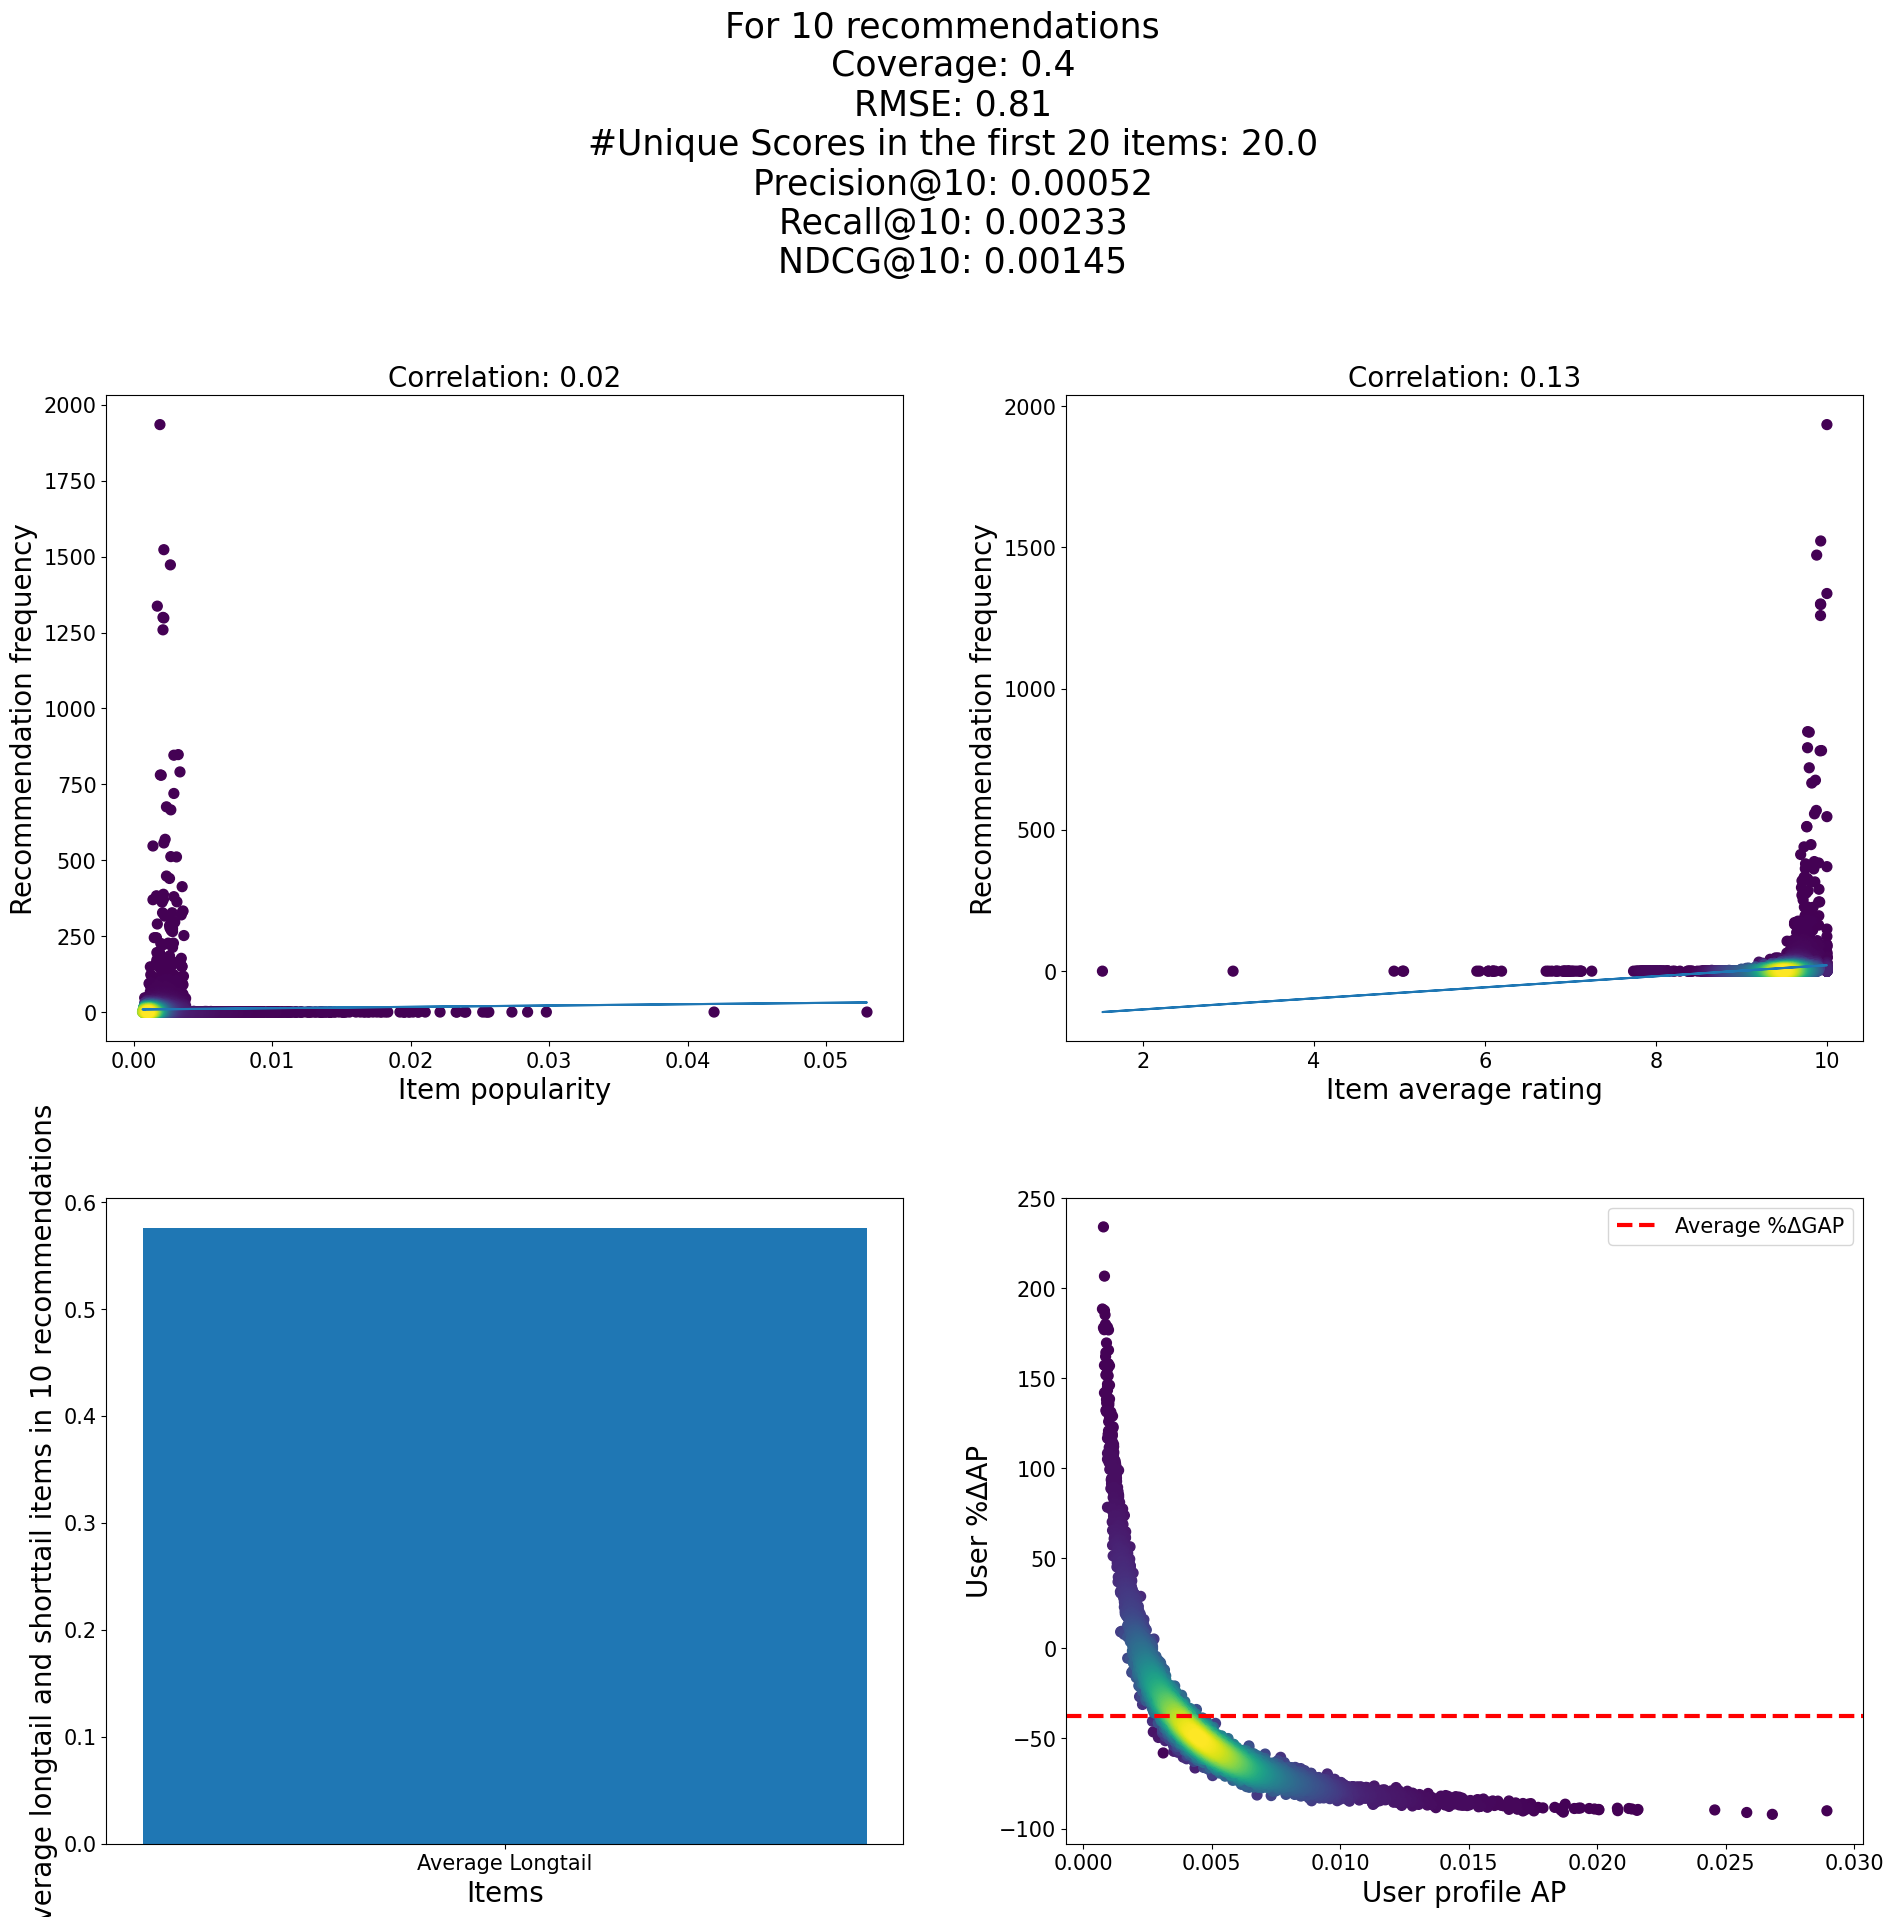

popularity_bad {'bias': False}
We got them already
nr of longtail 9366
7.363207547169812
nr of longtail 9924
7.80188679245283
nr of longtail 9533
7.494496855345912
nr of longtail 10202
8.026750590086547
nr of longtail 9696
7.628638867033832


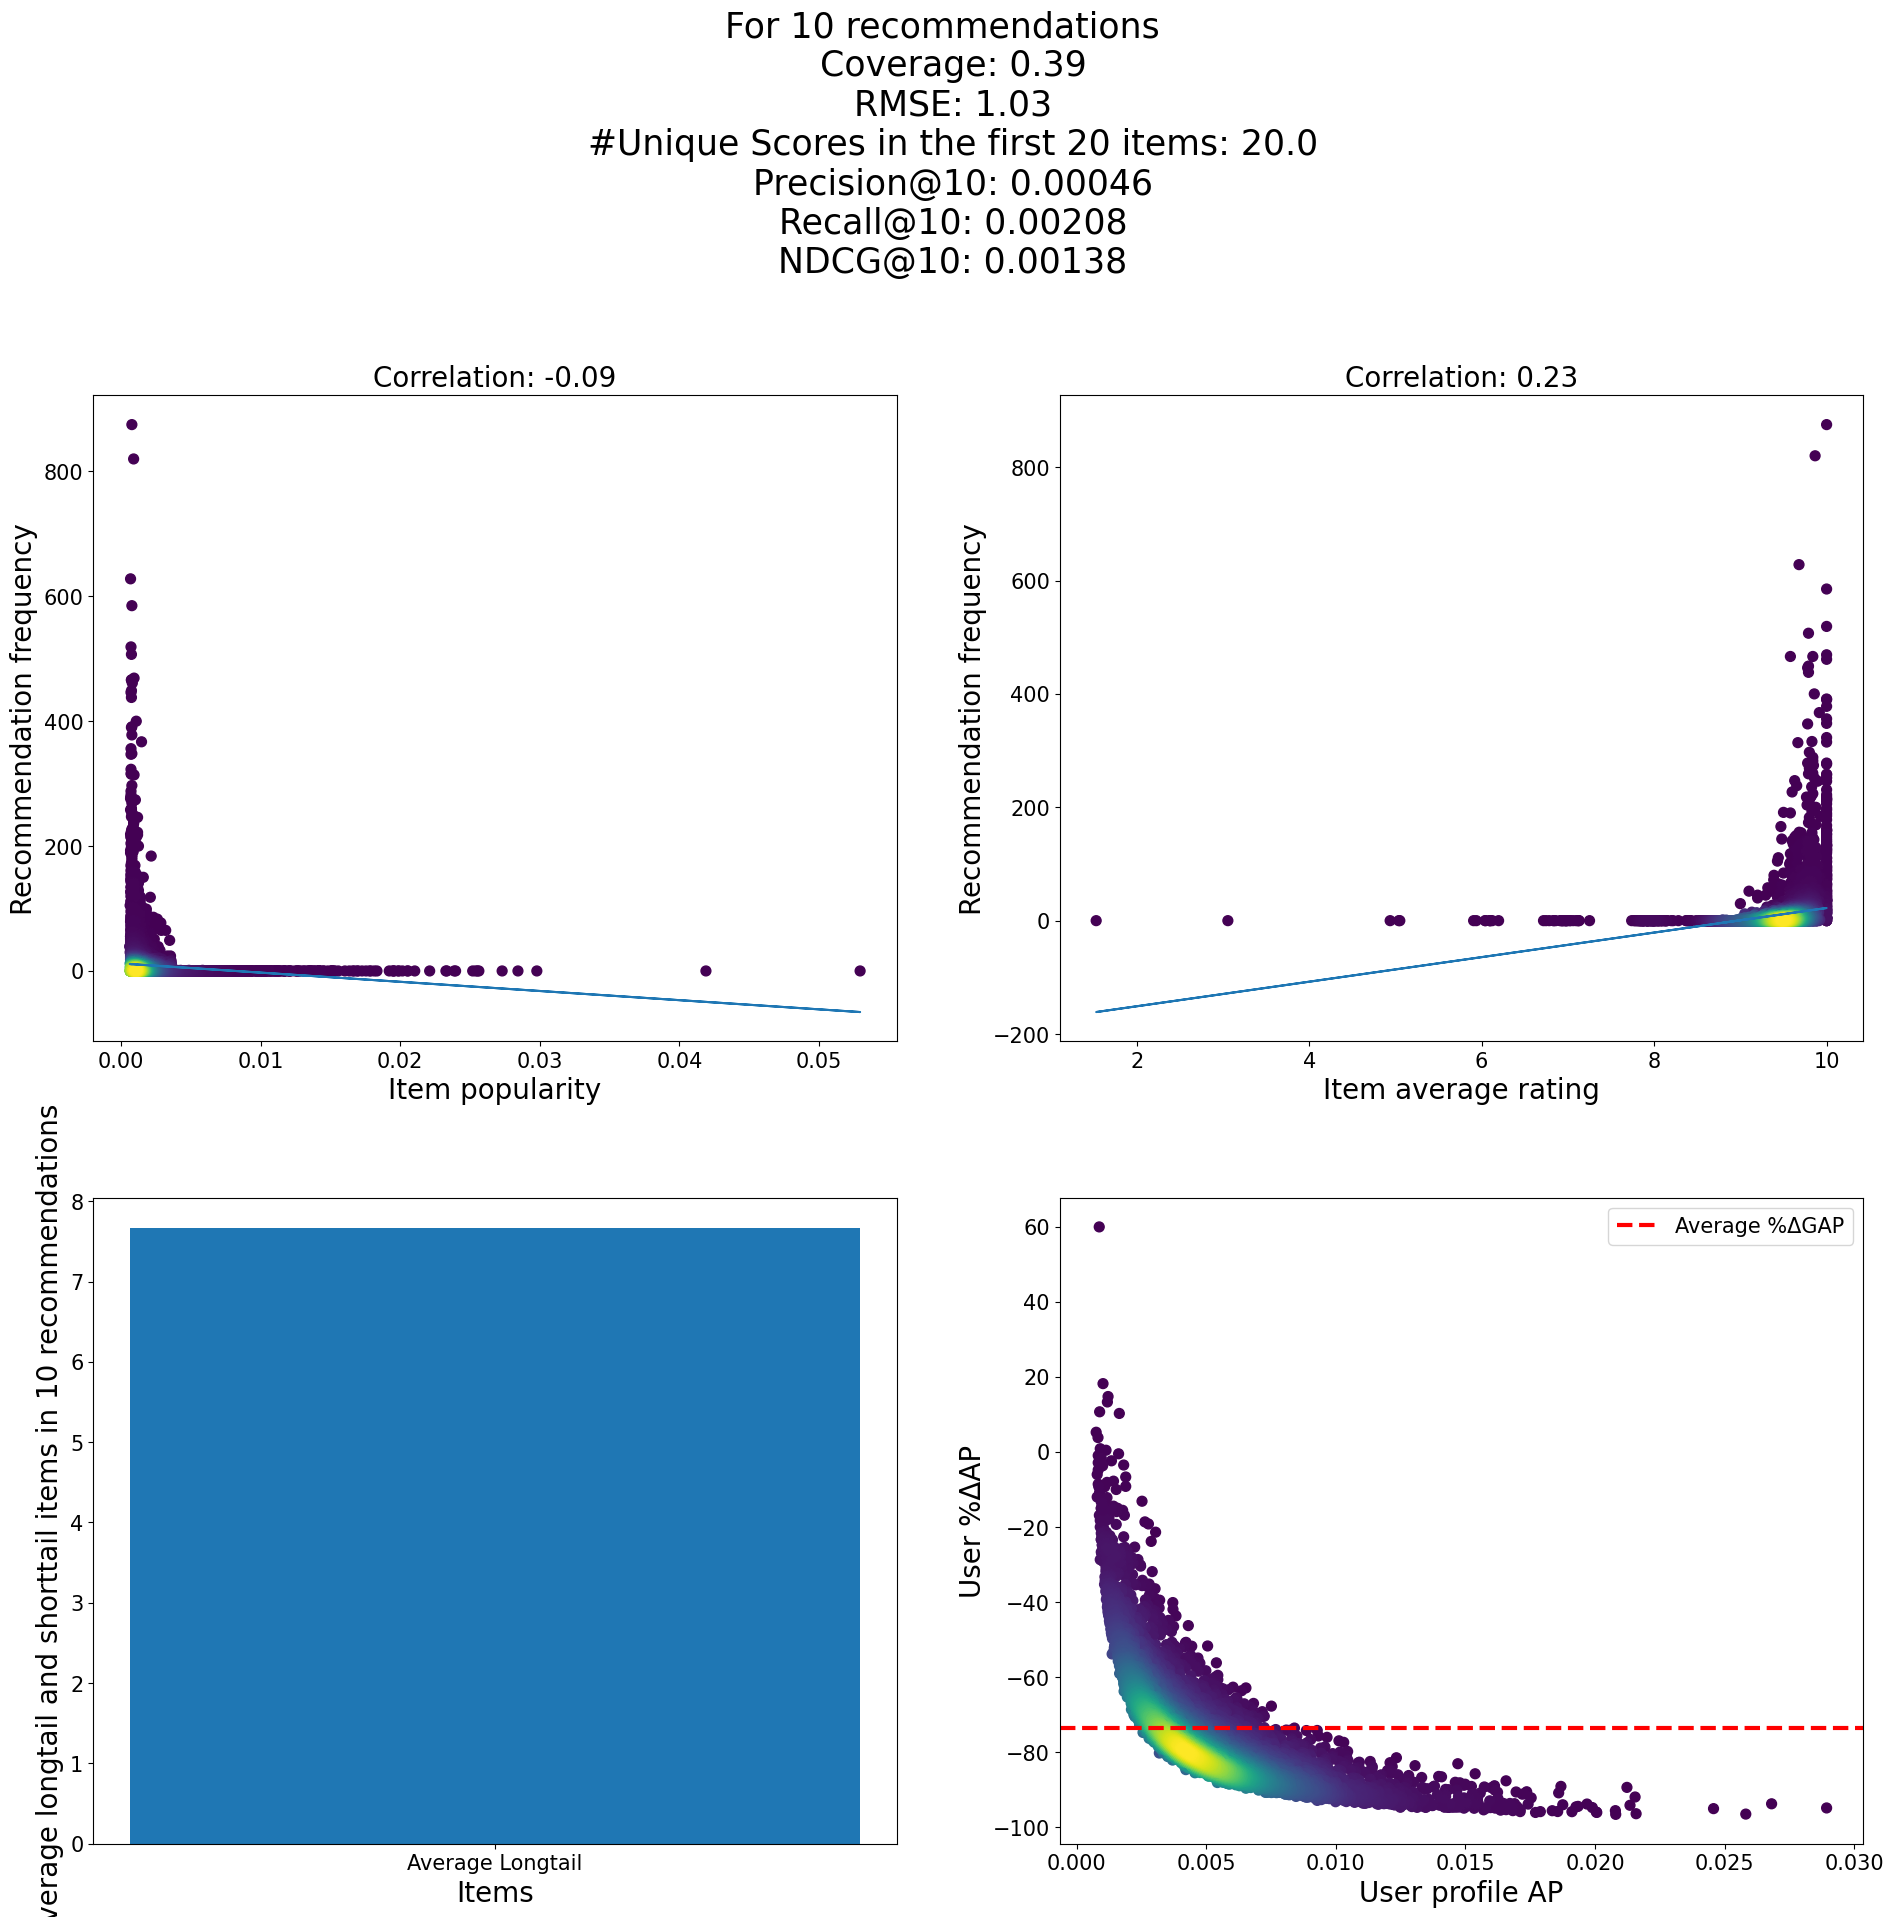

popularity_good_for_bp_ur {'bias': True}
We got them already
nr of longtail 5565
4.375
nr of longtail 6175
4.854559748427673
nr of longtail 6159
4.841981132075472
nr of longtail 6568
5.1675845790715975
nr of longtail 6317
4.970102281667978


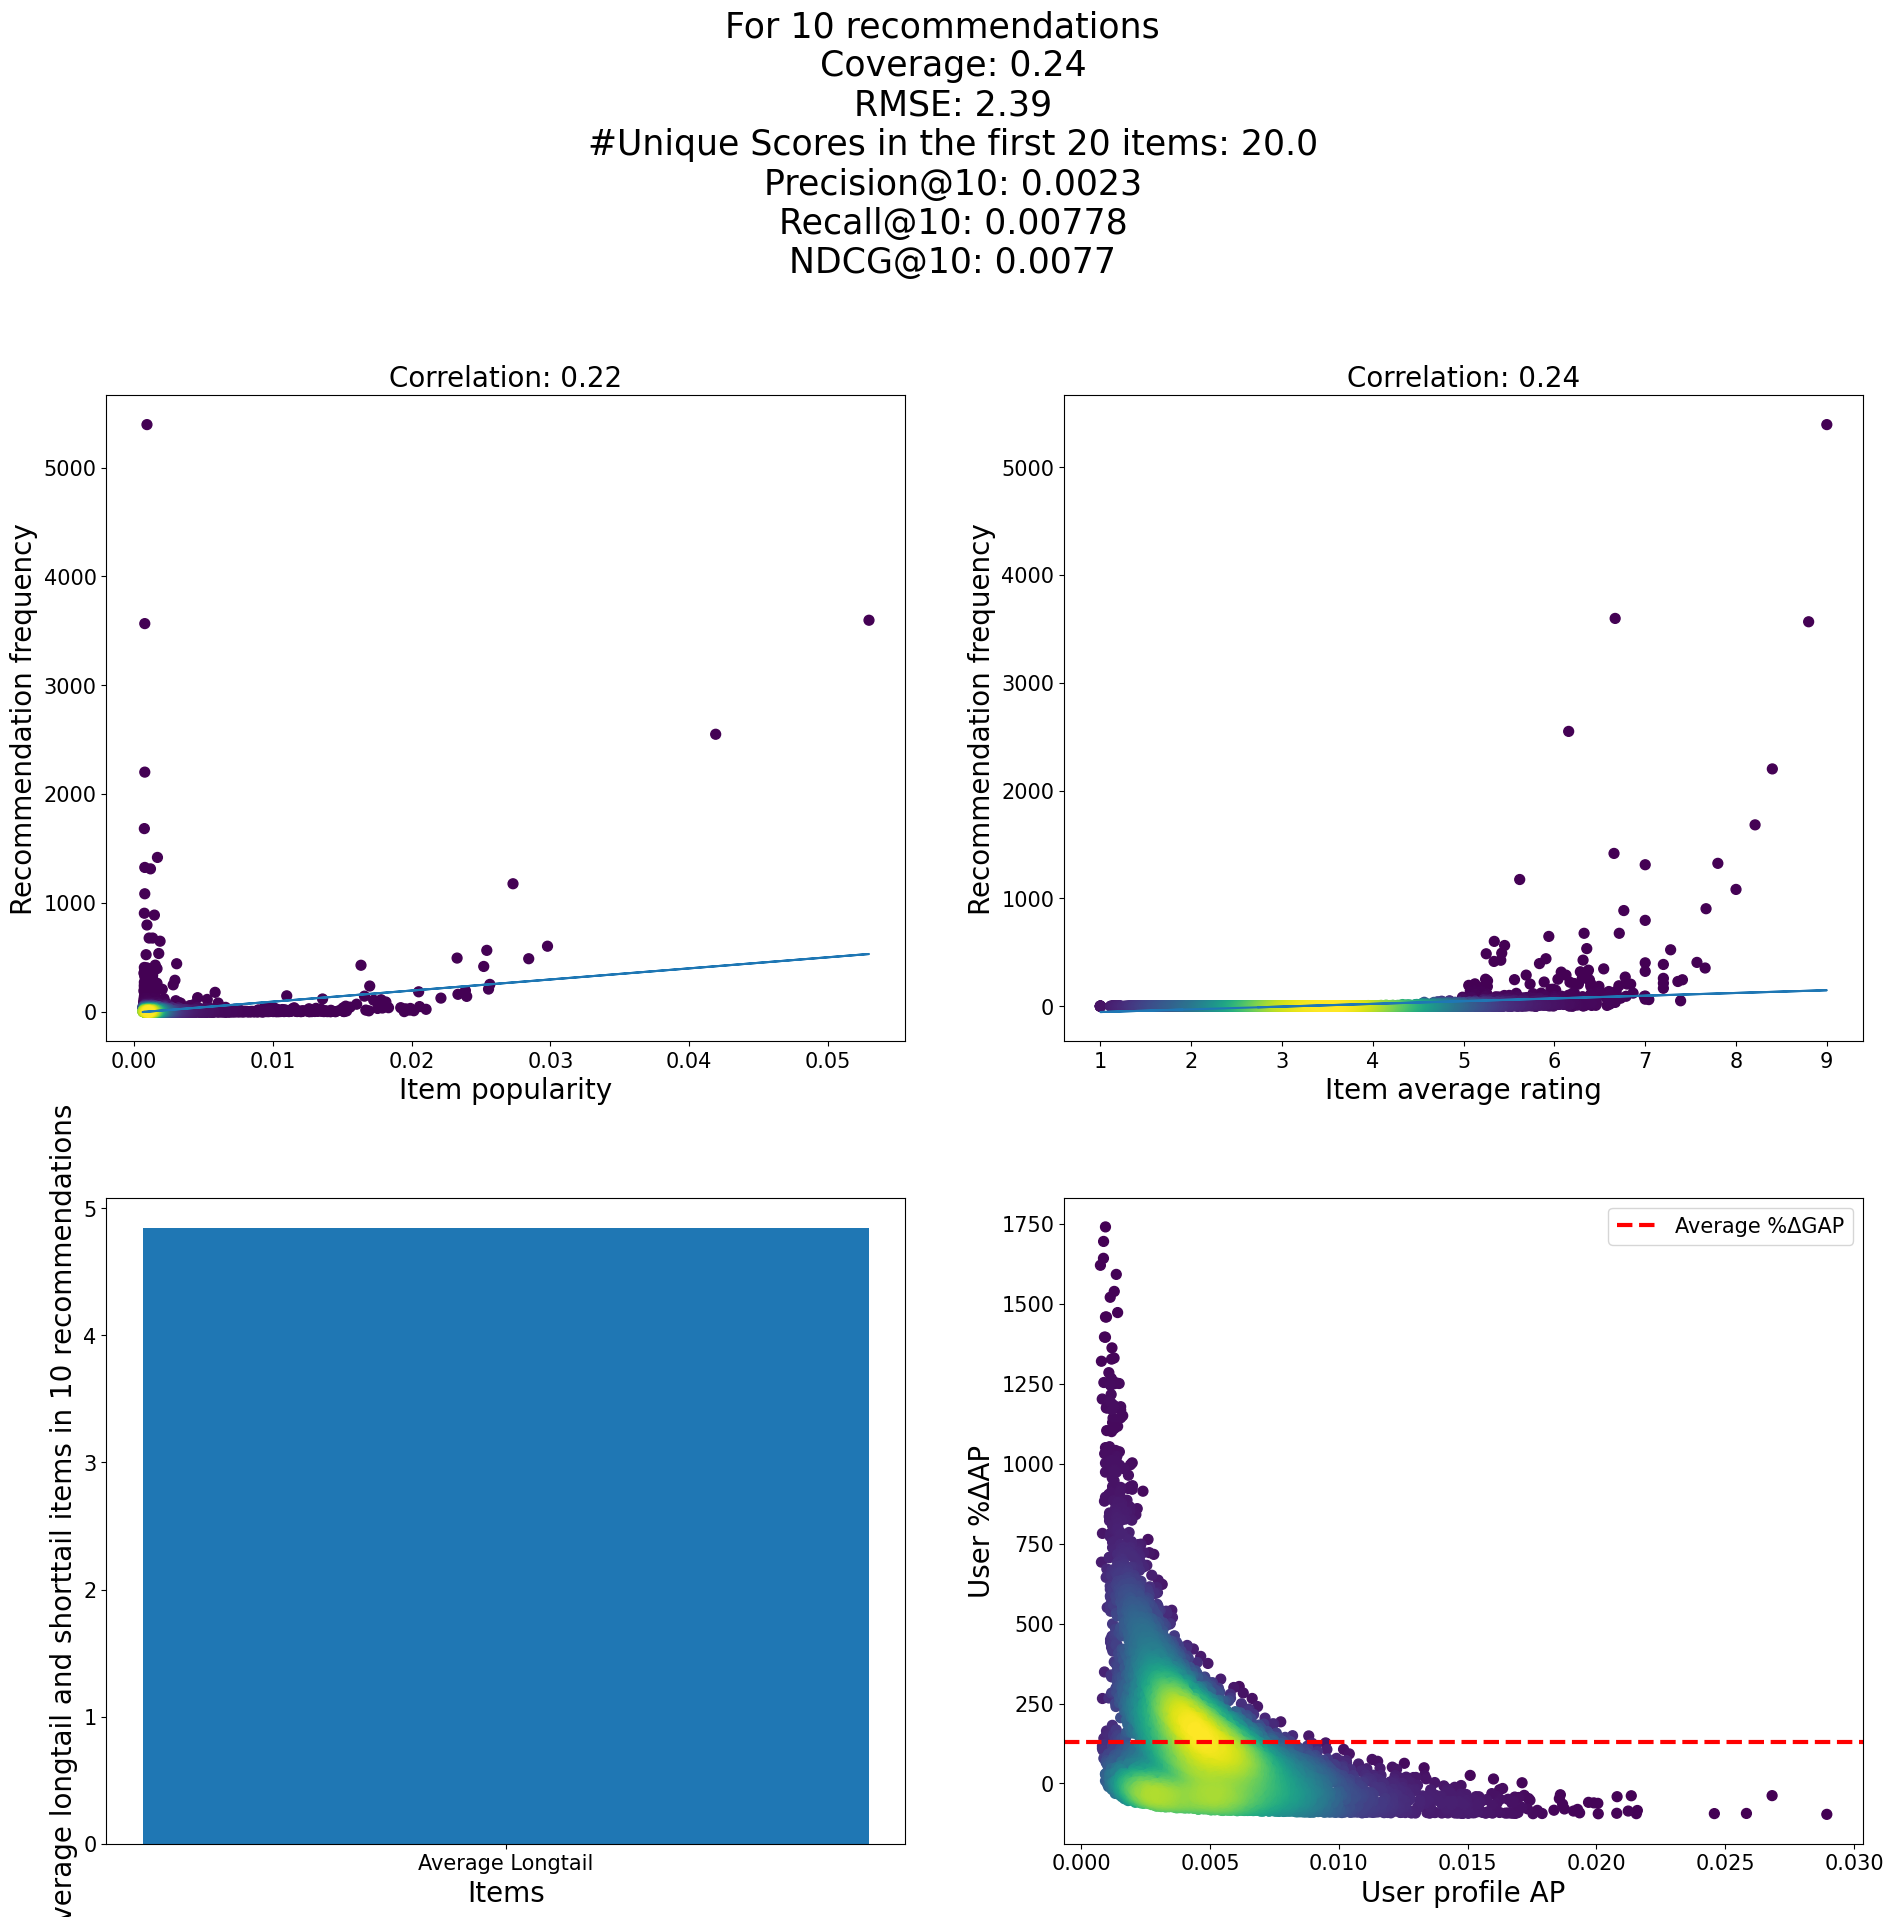

popularity_good_for_bp_ur {'bias': False}
We got them already
nr of longtail 5155
4.052672955974843
nr of longtail 5197
4.085691823899371
nr of longtail 5728
4.50314465408805
nr of longtail 5473
4.306058221872541
nr of longtail 5694
4.47993705743509


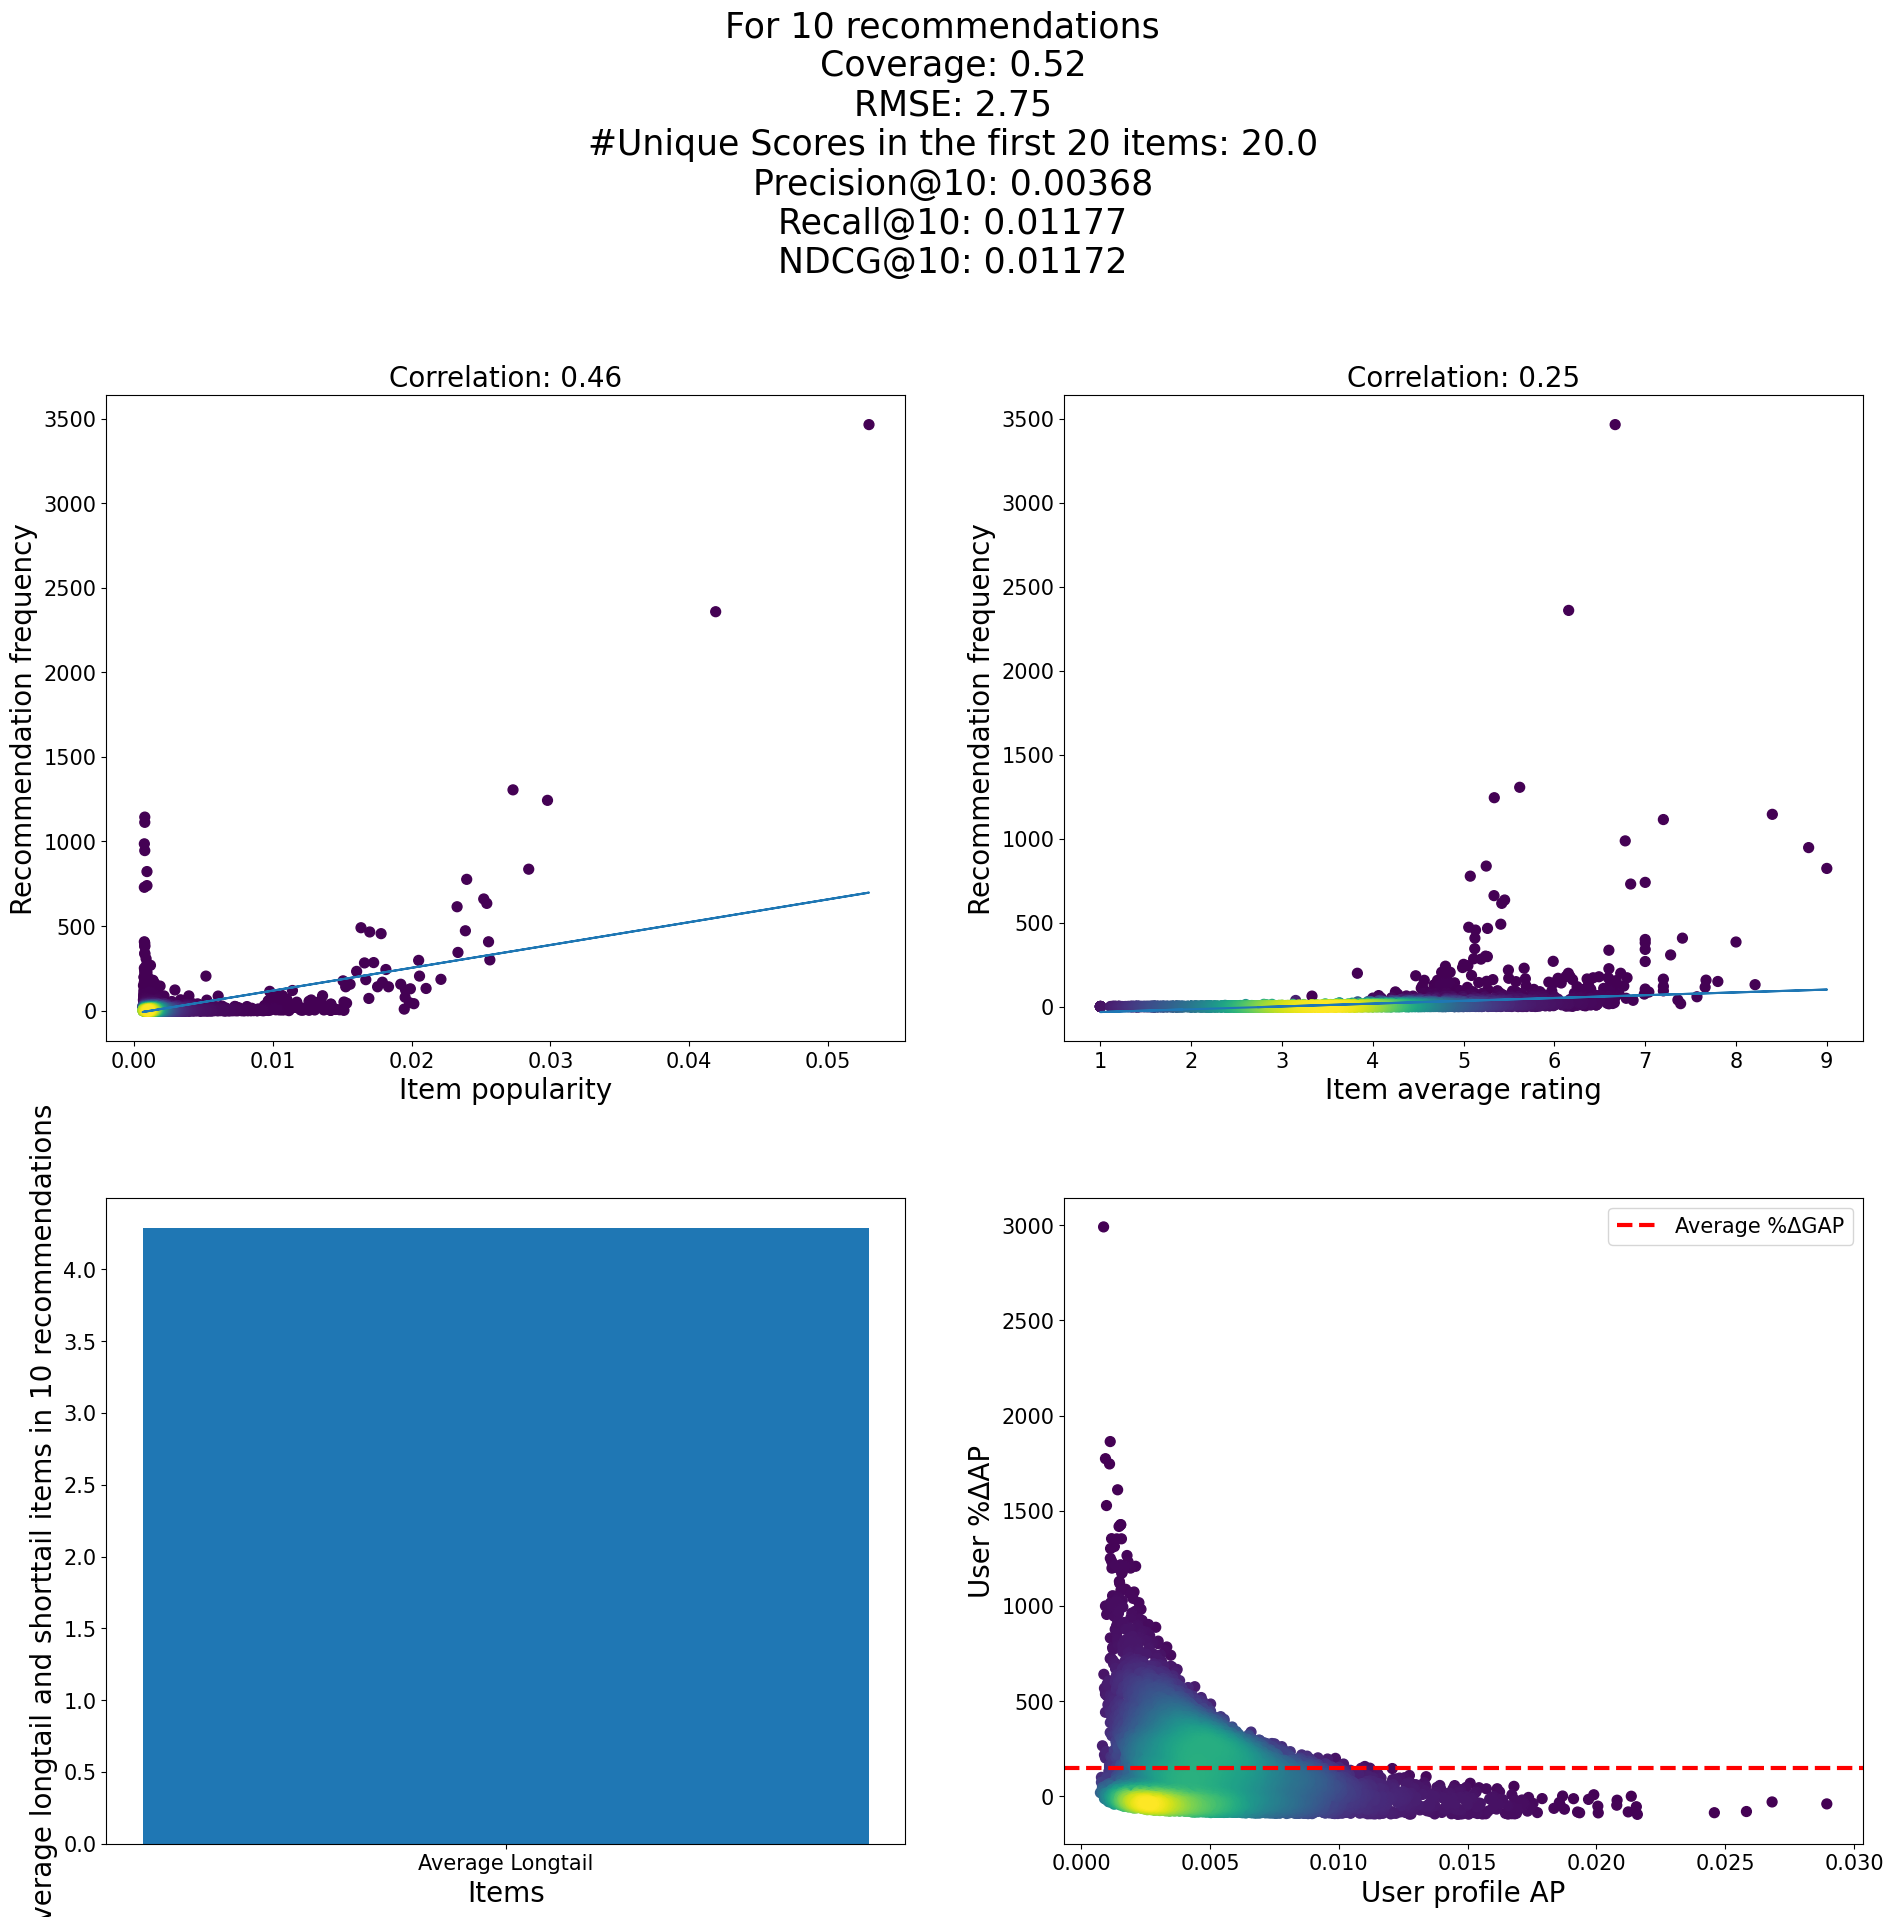

popularity_bad_for_bp_ur {'bias': True}
We got them already
nr of longtail 3499
2.7507861635220126
nr of longtail 3815
2.9992138364779874
nr of longtail 3819
3.0023584905660377
nr of longtail 4314
3.3941778127458693
nr of longtail 3946
3.104642014162077


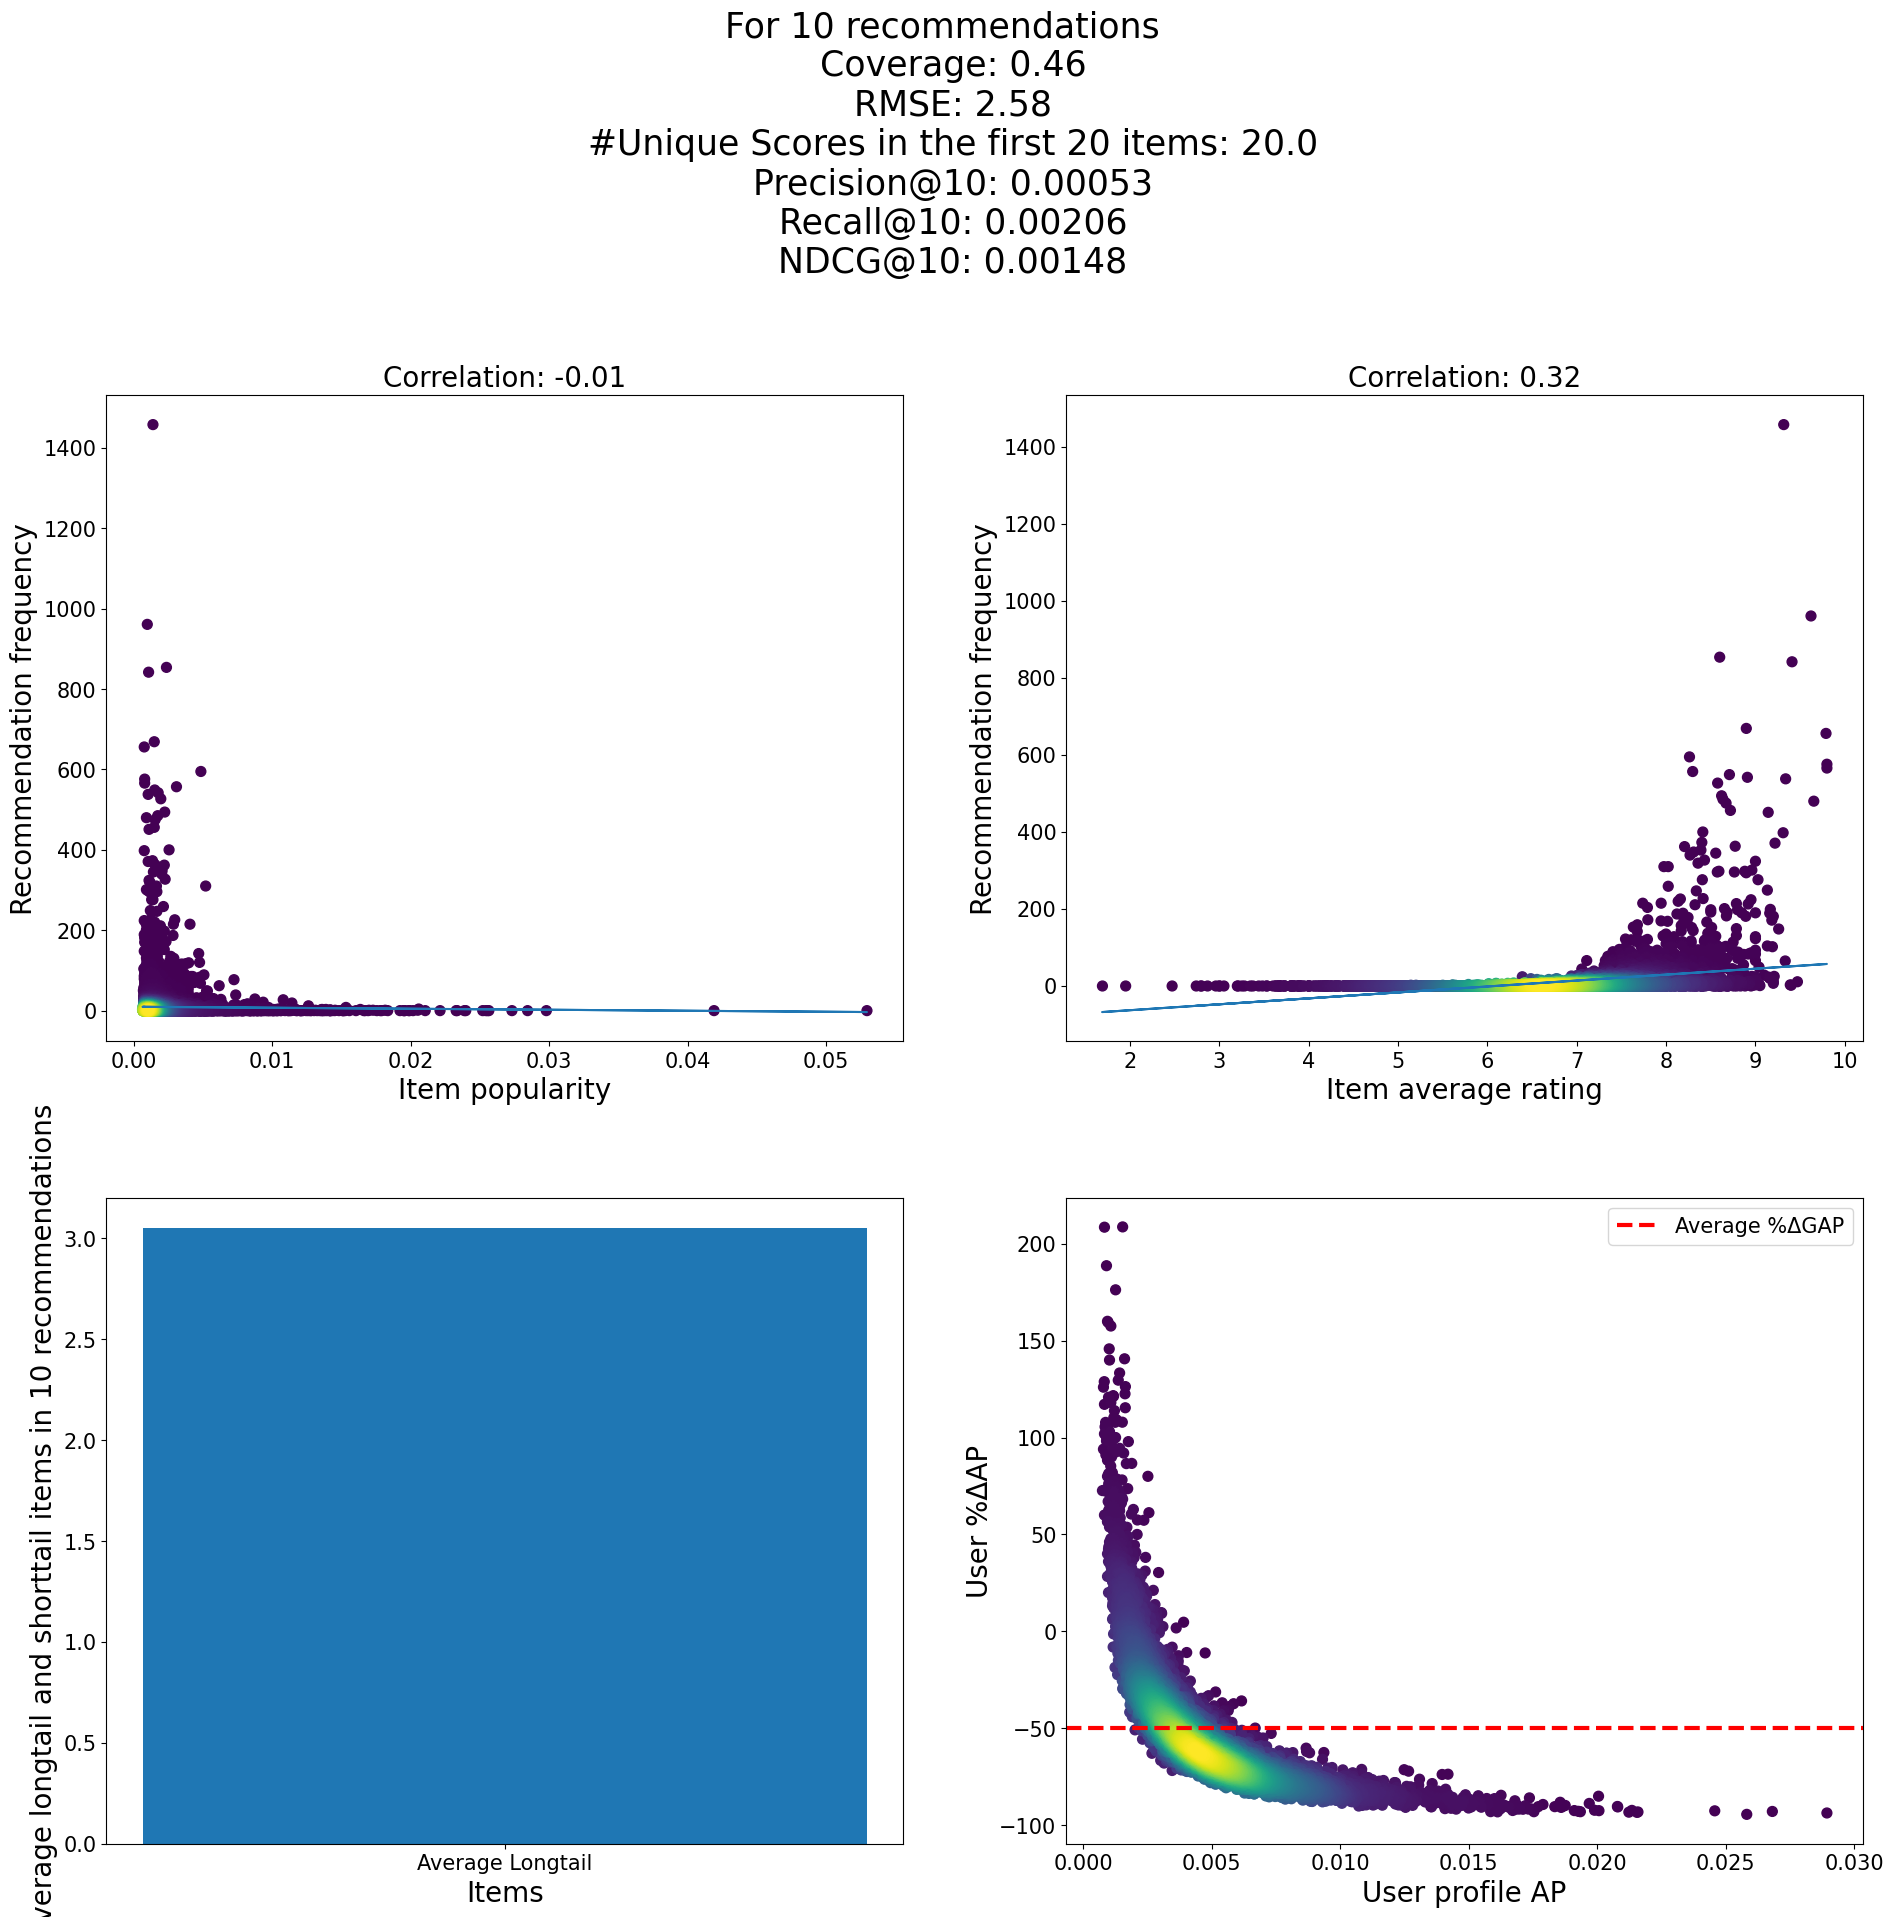

popularity_bad_for_bp_ur {'bias': False}
We got them already
nr of longtail 6381
5.0165094339622645


In [ ]:
# choose algorithm
algorithm_lkpy = als.BiasedMF
algo_name = "MF"
versions = algo_versions[algo_name]

# for every data strategy
for i in range(len(data_strategies)):
    data_strategy = data_strategies[i]
    # generate the data
    ratings = generate_data(
        strategy=data_strategy, copying_dataset=fairbook_ratings, user_perc=0.2
    )

    # for every 'fixed' version of the algorithm
    for args in versions:
        print(data_strategy, args)

        p = "best_parameters/" + algo_name + "/" + data_strategy + "_" + str(args) + ".pkl"
        if os.path.isfile(p):
            print("We got them already")
            with open(p, "rb") as f:
                best_params = pickle.load(f)
        else:
            print("We have to compute them now")
            # optimize for this fixed version
            best_params = optimize_lkpy(
                ratings=ratings, algorithm_name=algo_name, args=args, max_evals=20, partition_way = 'row'
            )
    
            # save the best parameters for this fixed version
    
            with open(
                "best_parameters/"
                + algo_name
                + "/"
                + data_strategy
                + "_"
                + str(args)
                + ".pkl",
                "wb",
            ) as f:
                pickle.dump(best_params, f)

        
        # # optimize for this fixed version
        # best_params = optimize_lkpy(
        #     ratings=ratings,
        #     algorithm_name=algo_name,
        #     args=args,
        #     partition_way="row",
        #     max_evals=20,
        # )

        # # save the best parameters for this fixed version

        # with open(
        #     "best_parameters/"
        #     + algo_name
        #     + "/"
        #     + data_strategy
        #     + "_"
        #     + str(args)
        #     + ".pkl",
        #     "wb",
        # ) as f:
        #     pickle.dump(best_params, f)

        reg_list = [0, 0.001, 0.01, 0.1]
        features_list = [10, 50, 100]
        optimal_reg = reg_list[best_params["reg"]]
        optimal_features = features_list[best_params["features"]]

        # run the training and evaluation for the fixed version + the best other parameters
        pop_biases_lkpy, metrics_dict_lkpy, GAP_vs_GAP_lkpy = modelling_mf.train_algorithm(
            algorithm=lambda: algorithm_lkpy(
                features=optimal_features, reg=optimal_reg, bias=args["bias"]
            ),
            algo_name=algo_name,
            ratings=ratings,
            evaluation_way=evaluation_way,
            verbose=verbose,
            n=nr_recs,
            sampling_strategy=sampling_strategy,
            partition_way=partition_way,
            plot=plot,
            data_strategy=data_strategy,
            args=args,
            save_plot=save_plot,
        )

        # Save metrics!
        with open(
            "experimental_results/"
            + algo_name
            + "/"
            + data_strategy
            + "_"
            + str(args)
            + ".pkl",
            "wb",
        ) as f:
            pickle.dump(metrics_dict_lkpy, f)
        with open('experimental_results/'+algo_name+'/detailed_per_item_'+data_strategy+'_'+str(args)+'.pkl', 'wb') as f:
            pickle.dump(pop_biases_lkpy, f)
        with open('experimental_results/'+algo_name+'/correct_detailed_per_item_'+data_strategy+'_'+str(args)+'.pkl', 'wb') as f:
            pickle.dump(GAP_vs_GAP_lkpy, f)

## Optimize, train, evaluate Cornac
- **Algorithm**
- **Fixed parameters**
- **To-optimize parameters**

In [ ]:
algo_versions = {"CornacMF": [{"bias": True}, {"bias": False}]}

In [ ]:
algorithm_cornac = MF
algo_name = "CornacMF"
versions = algo_versions[algo_name]

# for every data strategy
for i in range(len(data_strategies)):
    data_strategy = data_strategies[i]
    # generate the data
    ratings = generate_data(
        strategy=data_strategy, copying_dataset=fairbook_ratings, user_perc=0.2
    )
    # for every 'fixed' version of the algorithm
    for args in versions:
        print(data_strategy, args)


        p = "best_parameters/" + algo_name + "/" + data_strategy + "_" + str(args) + ".pkl"
        if os.path.isfile(p):
            print("We got them already")
            with open(p, "rb") as f:
                best_params = pickle.load(f)
        else:
            print("We have to compute them now")
            # optimize for this fixed version
            best_params = optimize_cornac(
                ratings=ratings, algorithm_name=algo_name, args=args, max_evals=20
            )
    
            # save the best parameters for this fixed version
    
            with open(
                "best_parameters/"
                + algo_name
                + "/"
                + data_strategy
                + "_"
                + str(args)
                + ".pkl",
                "wb",
            ) as f:
                pickle.dump(best_params, f)
                
        # # optimize for this fixed version
        # best_params = optimize_cornac(
        #     ratings=ratings, algorithm_name=algo_name, args=args, max_evals=20
        # )

        # # save the best parameters for this fixed version

        # with open(
        #     "best_parameters/"
        #     + algo_name
        #     + "/"
        #     + data_strategy
        #     + "_"
        #     + str(args)
        #     + ".pkl",
        #     "wb",
        # ) as f:
        #     pickle.dump(best_params, f)

        optimal_k = best_params["k"]
        optimal_reg = best_params["lambda_reg"]
        optimal_lr = best_params["learning_rate"]

        pop_biases_cornac, metrics_dict_cornac, GAP_vs_GAP_cornac = modelling_mf.train_algorithm_cornac(
            algorithm=lambda: algorithm_cornac(
                k=optimal_k,
                use_bias=args["bias"],
                lambda_reg=optimal_reg,
                learning_rate=optimal_lr,
            ),
            algo_name=algo_name,
            ratings=ratings,
            evaluation_way=evaluation_way,
            verbose=verbose,
            n=nr_recs,
            sampling_strategy=sampling_strategy,
            partition_way=partition_way,
            plot=plot,
            data_strategy=data_strategy,
            args=args,
            save_plot=save_plot,
        )

        # Save metrics!
        with open(
            "experimental_results/"
            + algo_name
            + "/"
            + data_strategy
            + "_"
            + str(args)
            + ".pkl",
            "wb",
        ) as f:
            pickle.dump(metrics_dict_cornac, f)
        with open('experimental_results/'+algo_name+'/detailed_per_item_'+data_strategy+'_'+str(args)+'.pkl', 'wb') as f:
            pickle.dump(pop_biases_cornac, f)
        with open('experimental_results/'+algo_name+'/correct_detailed_per_item_'+data_strategy+'_'+str(args)+'.pkl', 'wb') as f:
            pickle.dump(GAP_vs_GAP_cornac, f)